In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.stats import sigmaclip
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE, SelectKBest, chi2


import warnings
warnings.filterwarnings('ignore')

In [2]:
dataframe = pd.read_csv('telecom_churn.csv')
dataframe['Area code'] = dataframe['Area code'].astype(str)
numeric = dataframe.select_dtypes(include='number').columns
OUTPUT_COLUMN = 'Churn'
dataframe.head(5)

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
dataframe.drop(columns=('State'), inplace=True)

In [4]:
# Проверяю, есть ли значения, которые нужно исправлять
categorical = ['Area code', 'International plan', 'Voice mail plan']
for column in categorical:
    print(dataframe[column].unique())

['415' '408' '510']
['No' 'Yes']
['Yes' 'No']


Удаление выбросов

In [5]:
def sigma_clip(frame, column):
    """
    Удаление выбросов из столбца методом сигм
    :param frame: Таблица DataFrame библиотеки Pandas
    :param column: Название столбца таблицы
    :return: Новый столбец с удаленными выбросами
    """
    clipped = sigmaclip(frame[column].dropna())
    lower_border, upper_border = clipped[1], clipped[2]
    return frame[(frame[column] >= lower_border)
                 & (frame[column] <= upper_border)
                 | (np.isnan(frame[column]))].reset_index(drop=True)

In [6]:
print(f"Размер исходной таблицы - {len(dataframe)}")
for column in numeric:
    dataframe = sigma_clip(dataframe, column)
print(f"Размер новой таблицы - {len(dataframe)}")

Размер исходной таблицы - 3333
Размер новой таблицы - 3295


# Кодирование категориальных столбцов

In [7]:
# Кодирование столбцов
def encode_onehot_categorical(frame, columns):
    """
    Кодирует столбцы columns с помощью OneHotEncoder, удаляя первоначальные столбцы.
    :param frame: таблица DataFrame
    :param columns: кодируемые столбцы
    :return: новая таблица
    """
    encoder = OneHotEncoder()
    for column in columns:
        transformed = encoder.fit_transform(frame[[column]]).toarray()[:, 1:]
        new_frame = pd.DataFrame(transformed, columns=encoder.get_feature_names_out()[1:], index=frame.index)
        frame = frame.join(new_frame)
    frame = frame.drop(columns=columns)
    return frame



In [8]:
dataframe = encode_onehot_categorical(dataframe, categorical)
dataframe.head(5)

,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,Area code_415,Area code_510,International plan_Yes,Voice mail plan_Yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False,1.0,0.0,0.0,1.0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False,1.0,0.0,0.0,1.0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False,1.0,0.0,0.0,0.0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False,0.0,0.0,1.0,0.0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False,1.0,0.0,1.0,0.0


# Масштабирование

In [9]:
dataframe[numeric] = MinMaxScaler().fit_transform(dataframe[numeric])
dataframe

,Account length,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn,Area code_415,Area code_510,International plan_Yes,Voice mail plan_Yes
0,0.524793,0.490196,0.753877,0.592593,0.753885,0.499850,0.470149,0.500000,0.595750,0.408451,0.595935,0.500,0.230769,0.500000,0.166667,False,1.0,0.0,0.0,1.0
1,0.438017,0.509804,0.456634,0.688889,0.456588,0.494135,0.500000,0.494338,0.621840,0.492958,0.622236,0.685,0.230769,0.685185,0.166667,False,1.0,0.0,0.0,1.0
2,0.561983,0.000000,0.691557,0.622222,0.691554,0.270677,0.552239,0.270701,0.374933,0.500000,0.375374,0.610,0.384615,0.609259,0.000000,False,1.0,0.0,0.0,0.0
3,0.342975,0.000000,0.852384,0.303704,0.852365,0.092331,0.388060,0.092357,0.467187,0.394366,0.467424,0.330,0.538462,0.329630,0.333333,False,0.0,0.0,1.0,0.0
4,0.305785,0.000000,0.471281,0.614815,0.471284,0.352180,0.641791,0.352442,0.440290,0.619718,0.440526,0.505,0.230769,0.505556,0.500000,False,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3290,0.789256,0.705882,0.441126,0.348148,0.441047,0.554286,0.671642,0.554494,0.688273,0.352113,0.688583,0.495,0.461538,0.494444,0.333333,False,1.0,0.0,0.0,1.0
3291,0.276860,0.000000,0.656232,0.200000,0.656250,0.367519,0.141791,0.367657,0.452125,0.633803,0.452481,0.480,0.307692,0.479630,0.500000,False,1.0,0.0,0.0,0.0
3292,0.111570,0.000000,0.511775,0.585185,0.511824,0.774737,0.164179,0.774947,0.453739,0.408451,0.454274,0.705,0.461538,0.705556,0.333333,False,0.0,1.0,0.0,0.0
3293,0.756198,0.000000,0.606548,0.555556,0.606588,0.386165,0.358209,0.386412,0.311996,0.732394,0.312014,0.250,0.769231,0.250000,0.333333,False,0.0,1.0,1.0,0.0


# Модели

In [10]:
# Список словарей со значенями имени, класса модели и параметров для GridSearch
models_data = [{'name': 'К-ближайших соседей', 'model': KNeighborsClassifier, 'params': {'n_neighbors':range(1, 11), 'weights':('uniform', 'distance'),
              'algorithm':('auto', 'ball_tree', 'kd_tree', 'brute')}},

              {'name': 'Логистическая регрессия', 'model': LogisticRegression,  'params': {'C':range(1, 10), 'penalty':(None, 'l1', 'l2', 'elasticnet'), 
              'solver':(['saga']), 'l1_ratio':([0.5])}},

              {'name': 'Метод опорных векторов', 'model':  SVC, 'params': {'kernel':('rbf', 'linear', 'poly'), 'C':(range(1, 10))}}
]

In [11]:
# Поиск лучших моделей с помощью GridSearch. Согласно документации, в GridSearch уже встроена кросс-валидация
def get_best_models(models_data, x_train, y_train):
    best_models = {}
    for data in models_data:
        grid = GridSearchCV(data['model'](), data['params'], scoring='roc_auc')
        grid.fit(x_train, y_train)
        best_model = grid.best_estimator_
        best_models[data['name']] = best_model
    return best_models



In [12]:
def get_metrics(y_true, y_predicted):
    return {"Accuracy": accuracy_score(y_true, y_predicted),
            "Precision": precision_score(y_true, y_predicted),
            "Recall": recall_score(y_true, y_predicted),
            "F1": f1_score(y_true, y_predicted),
            "Roc auc score": roc_auc_score(y_true, y_predicted)}
            

def create_roc_curve(y_true, y_predicted, name=None):
    fpr, tpr, _ = roc_curve(y_true, y_predicted)
    plt.plot(fpr, tpr)
    if name:
        plt.title(f"ROC AUC - {name}")
    else:
        plt.title("ROC AUC")
    plt.show()

In [13]:
# Словарь вида {метод предобработки: словарь метрик}
methods_and_scores = {}

Модель - К-ближайших соседей
Accuracy - 0.8762135922330098
Precision - 0.8620689655172413
Recall - 0.2032520325203252
F1 - 0.32894736842105254
Roc auc score - 0.5987729492130869


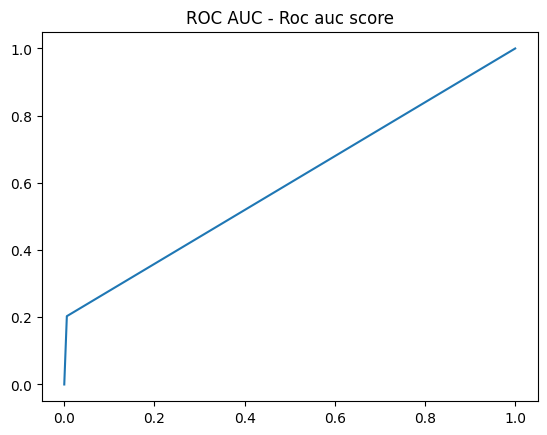

Модель - Логистическая регрессия
Accuracy - 0.8507281553398058
Precision - 0.5
Recall - 0.17073170731707318
F1 - 0.2545454545454546
Roc auc score - 0.5703872516613896


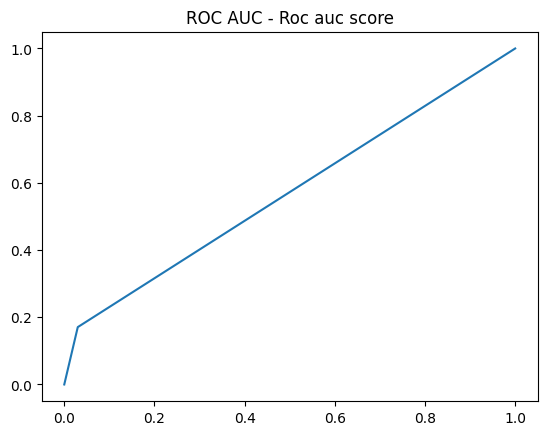

Модель - Метод опорных векторов
Accuracy - 0.9089805825242718
Precision - 0.8529411764705882
Recall - 0.4715447154471545
F1 - 0.6073298429319373
Roc auc score - 0.7286396901058882


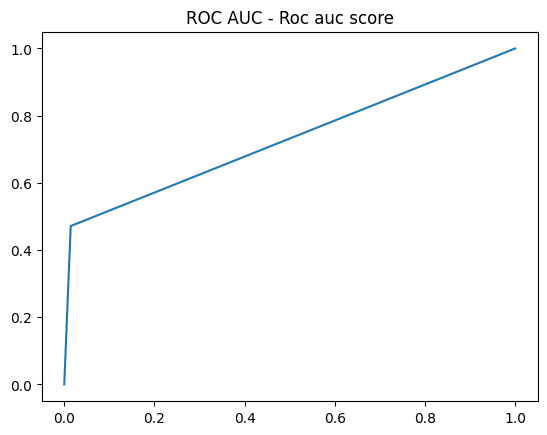

In [14]:
x_train, x_test, y_train, y_test = train_test_split(dataframe.drop(columns=OUTPUT_COLUMN), dataframe[OUTPUT_COLUMN])
best_models = get_best_models(models_data, x_train, y_train)
for name, model in best_models.items():
    predicted = model.predict(x_test)
    print(f"Модель - {name}")
    metrics = get_metrics(y_test, predicted)
    methods_and_scores['Только обязательные методы'] = metrics
    for name, value in metrics.items():
        print(f"{name} - {value}")
    create_roc_curve(y_test, predicted, name=name)

# Добавление квадратичных признаков

In [15]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
poly_x_train = poly_features.fit_transform(x_train)
poly_x_test = poly_features.fit_transform(x_test)





Модель - К-ближайших соседей
Accuracy - 0.8737864077669902
Precision - 0.88
Recall - 0.17886178861788618
F1 - 0.2972972972972973
Roc auc score - 0.5872910940236364


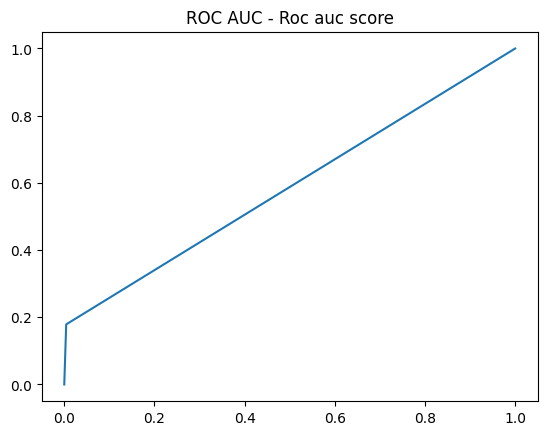

Модель - Логистическая регрессия
Accuracy - 0.9089805825242718
Precision - 0.8
Recall - 0.5203252032520326
F1 - 0.6305418719211824
Roc auc score - 0.7487503334377139


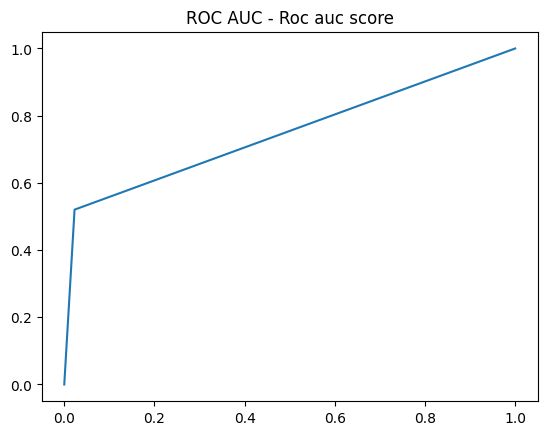

Модель - Метод опорных векторов
Accuracy - 0.9065533980582524
Precision - 0.859375
Recall - 0.44715447154471544
F1 - 0.588235294117647
Roc auc score - 0.7171578349164377


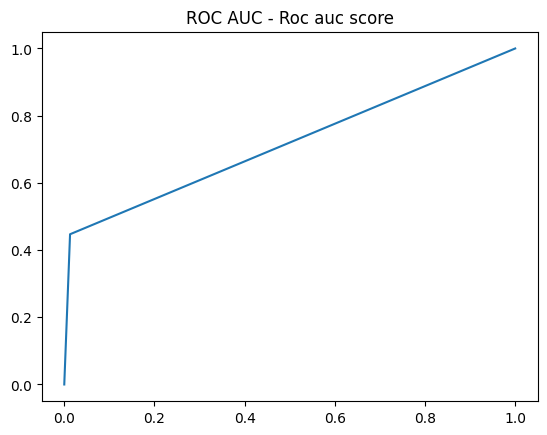

In [16]:
best_models = get_best_models(models_data, poly_x_train, y_train)
for name, model in best_models.items():
    predicted = model.predict(poly_x_test)
    print(f"Модель - {name}")
    metrics = get_metrics(y_test, predicted)
    methods_and_scores['Квадратичные признаки'] = metrics
    for name, value in metrics.items():
        print(f"{name} - {value}")
    create_roc_curve(y_test, predicted, name=name)

# Вычисление корреляции и удаление лишних столбцов

<Axes: >

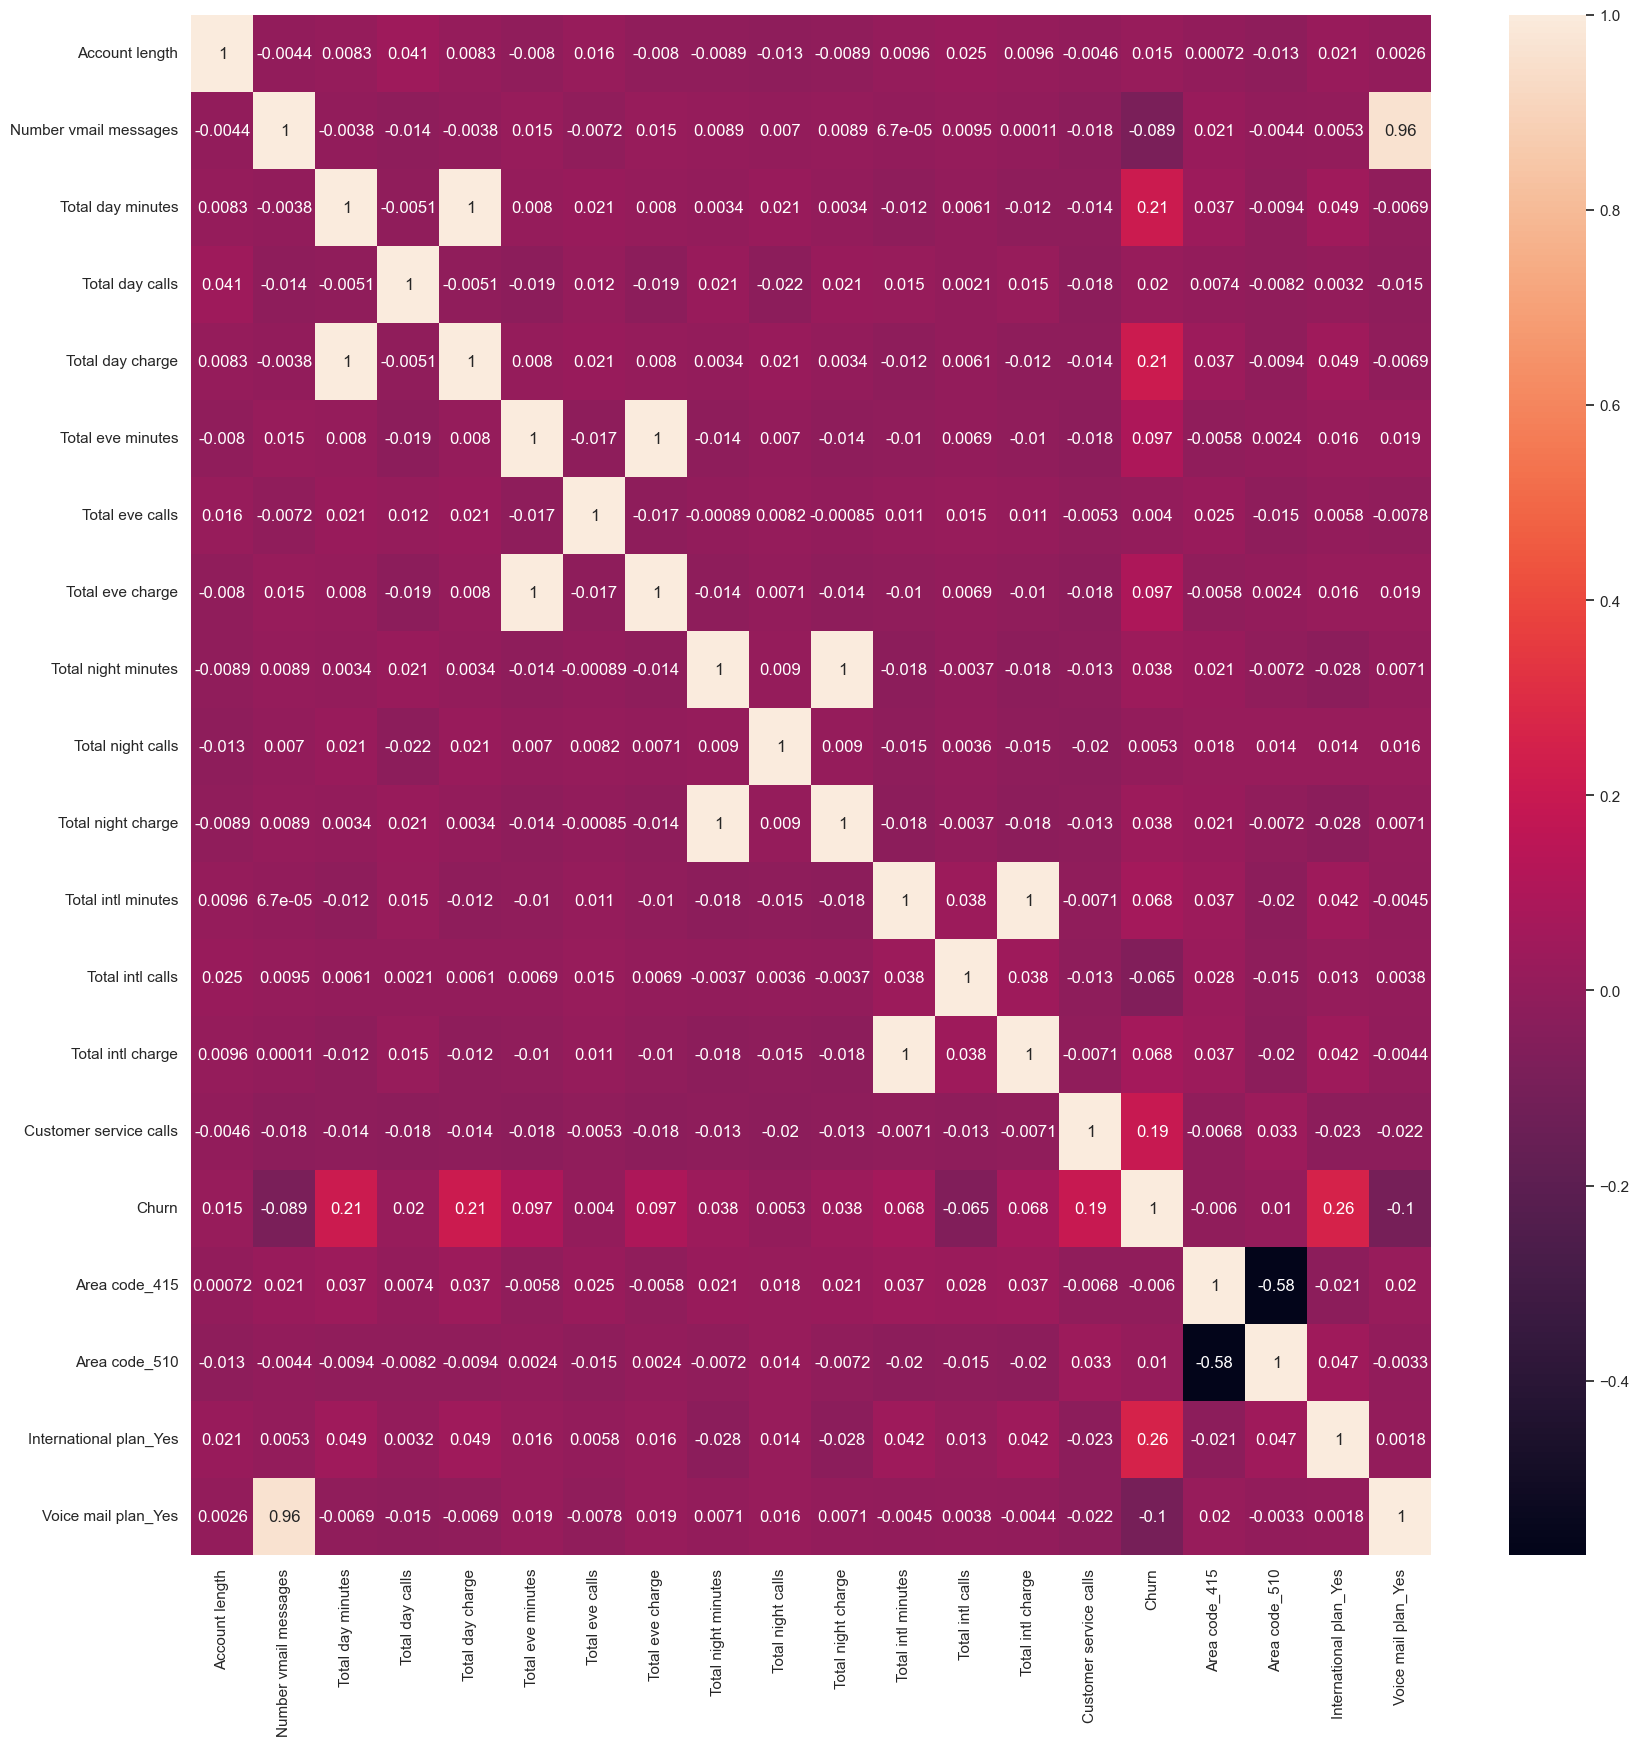

In [17]:
corr_df = dataframe.corr()
sns.set(rc={"figure.figsize": (20, 20)})
sns.heatmap(corr_df, annot=True)

Index(['Total day minutes', 'Total day charge', 'Customer service calls',
       'Churn', 'International plan_Yes', 'Voice mail plan_Yes'],
      dtype='object')

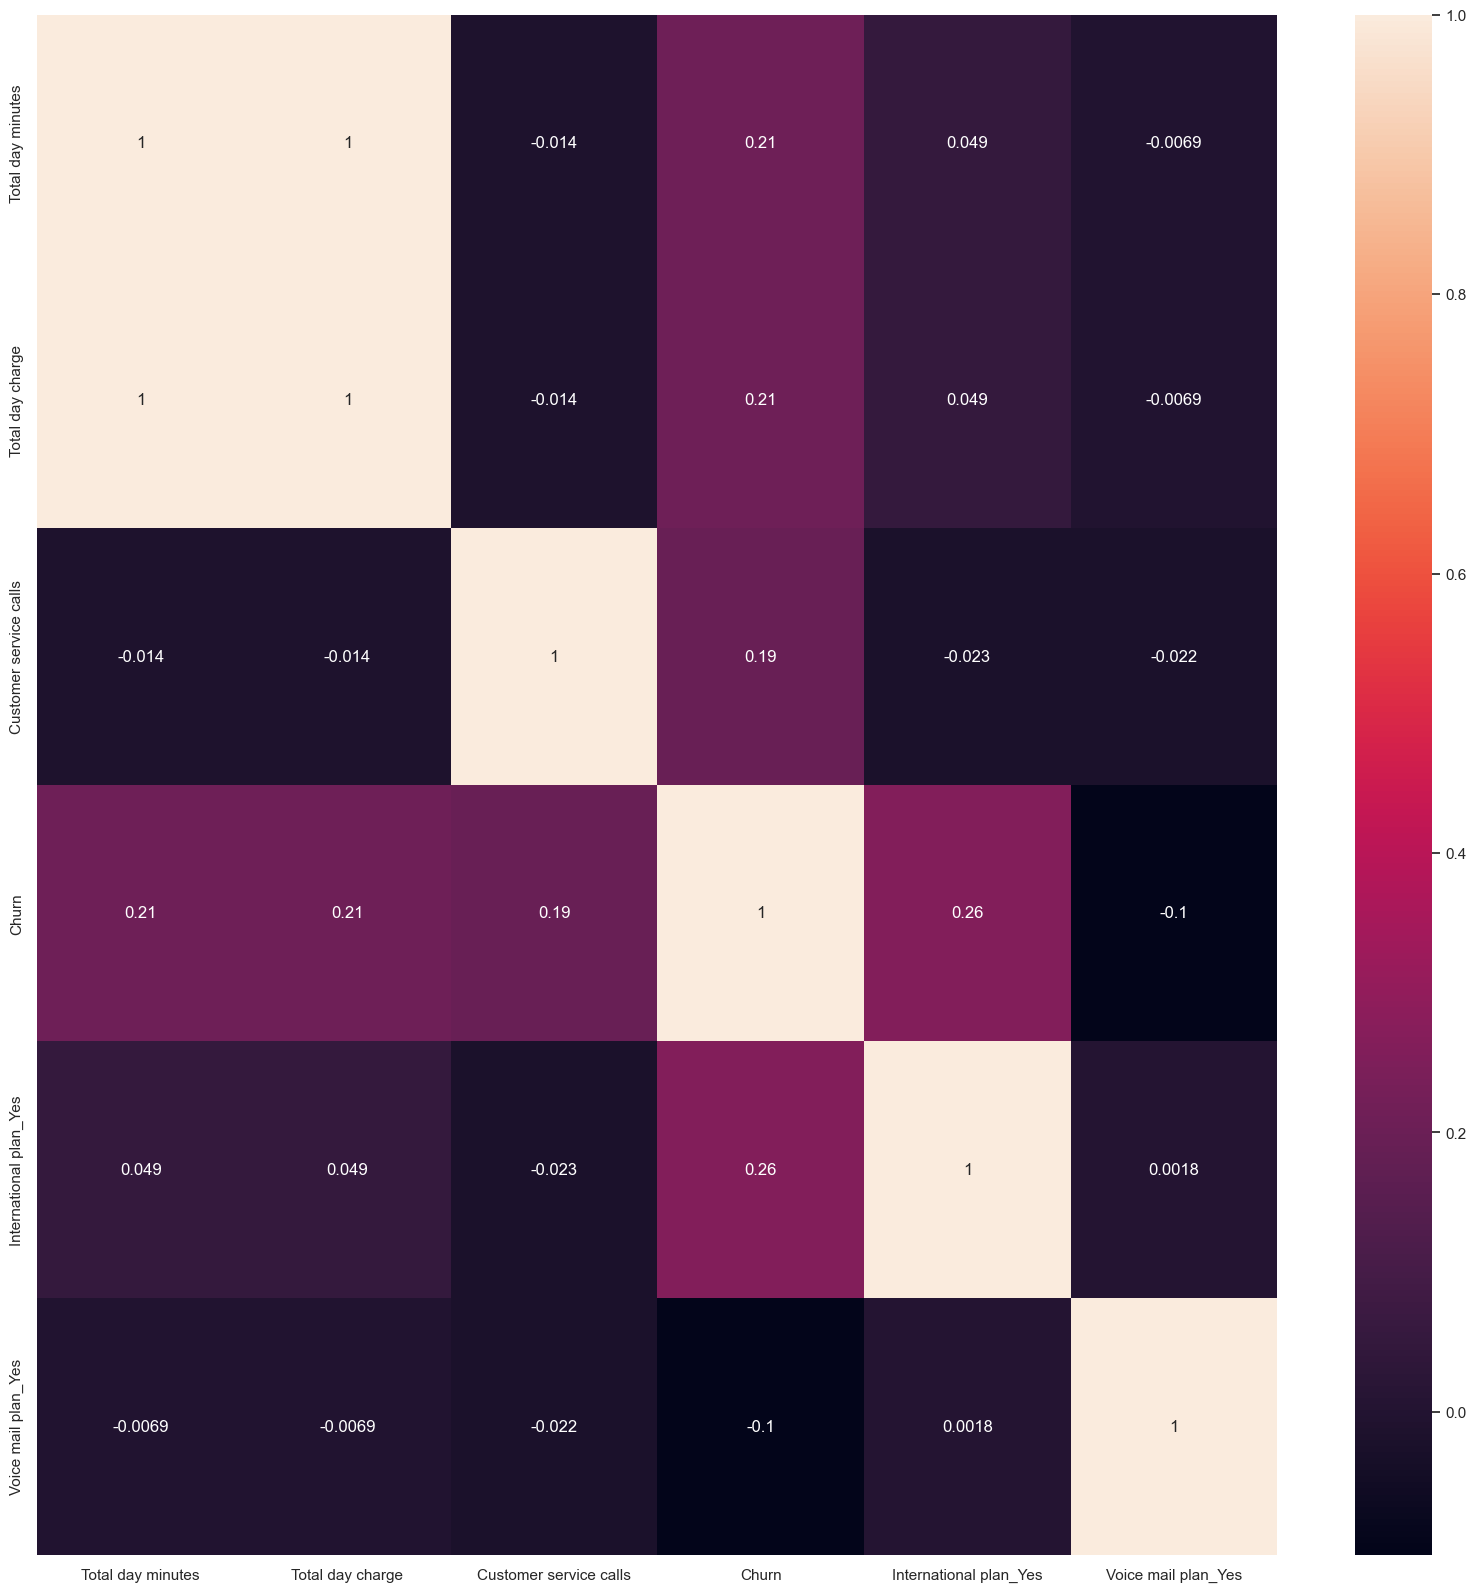

In [18]:
# Удаление признаков, слабо коррелирующих с целевой переменной
WEAK_CORR = 0.1
corr_df = corr_df.loc[abs(corr_df[OUTPUT_COLUMN]) > WEAK_CORR]
columns_left = corr_df.index
corr_df = corr_df[columns_left]
sns.heatmap(corr_df, annot=True)
columns_left

In [19]:
# Удаление признаков, сильно коррелирующих друг с другом
# Из-за того, что корреляция между оставшимися после прошлого пункта признаками слишком низкая, ни один из столбцов не будет удален
STRONG_CORR = 0.75
removed = set()
for row in corr_df.drop(index=OUTPUT_COLUMN, columns=OUTPUT_COLUMN).iterrows():
    row = row[0]
    for column in corr_df.drop(index=OUTPUT_COLUMN, columns=OUTPUT_COLUMN).columns:
        if STRONG_CORR <= corr_df[row][column] < 1:
            removed.add(min([row, column], key=lambda x: abs(corr_df[x][OUTPUT_COLUMN])))
        
corr_df = corr_df.drop(index=removed,  columns=removed)
corr_df


,Total day minutes,Customer service calls,Churn,International plan_Yes,Voice mail plan_Yes
Total day minutes,1.000000,-0.013798,0.211787,0.049331,-0.006897
Customer service calls,-0.013798,1.000000,0.194805,-0.022988,-0.022069
Churn,0.211787,0.194805,1.000000,0.260242,-0.102288
International plan_Yes,0.049331,-0.022988,0.260242,1.000000,0.001843
Voice mail plan_Yes,-0.006897,-0.022069,-0.102288,0.001843,1.000000


In [20]:
dataframe.columns

Index(['Account length', 'Number vmail messages', 'Total day minutes',
       'Total day calls', 'Total day charge', 'Total eve minutes',
       'Total eve calls', 'Total eve charge', 'Total night minutes',
       'Total night calls', 'Total night charge', 'Total intl minutes',
       'Total intl calls', 'Total intl charge', 'Customer service calls',
       'Churn', 'Area code_415', 'Area code_510', 'International plan_Yes',
       'Voice mail plan_Yes'],
      dtype='object')

In [21]:
x_train, x_test, y_train, y_test = train_test_split(dataframe[corr_df.columns].drop(columns=OUTPUT_COLUMN), dataframe[corr_df.columns][OUTPUT_COLUMN])

Модель - К-ближайших соседей
Accuracy - 0.8859223300970874
Precision - 0.6857142857142857
Recall - 0.4
F1 - 0.5052631578947367
Roc auc score - 0.684375


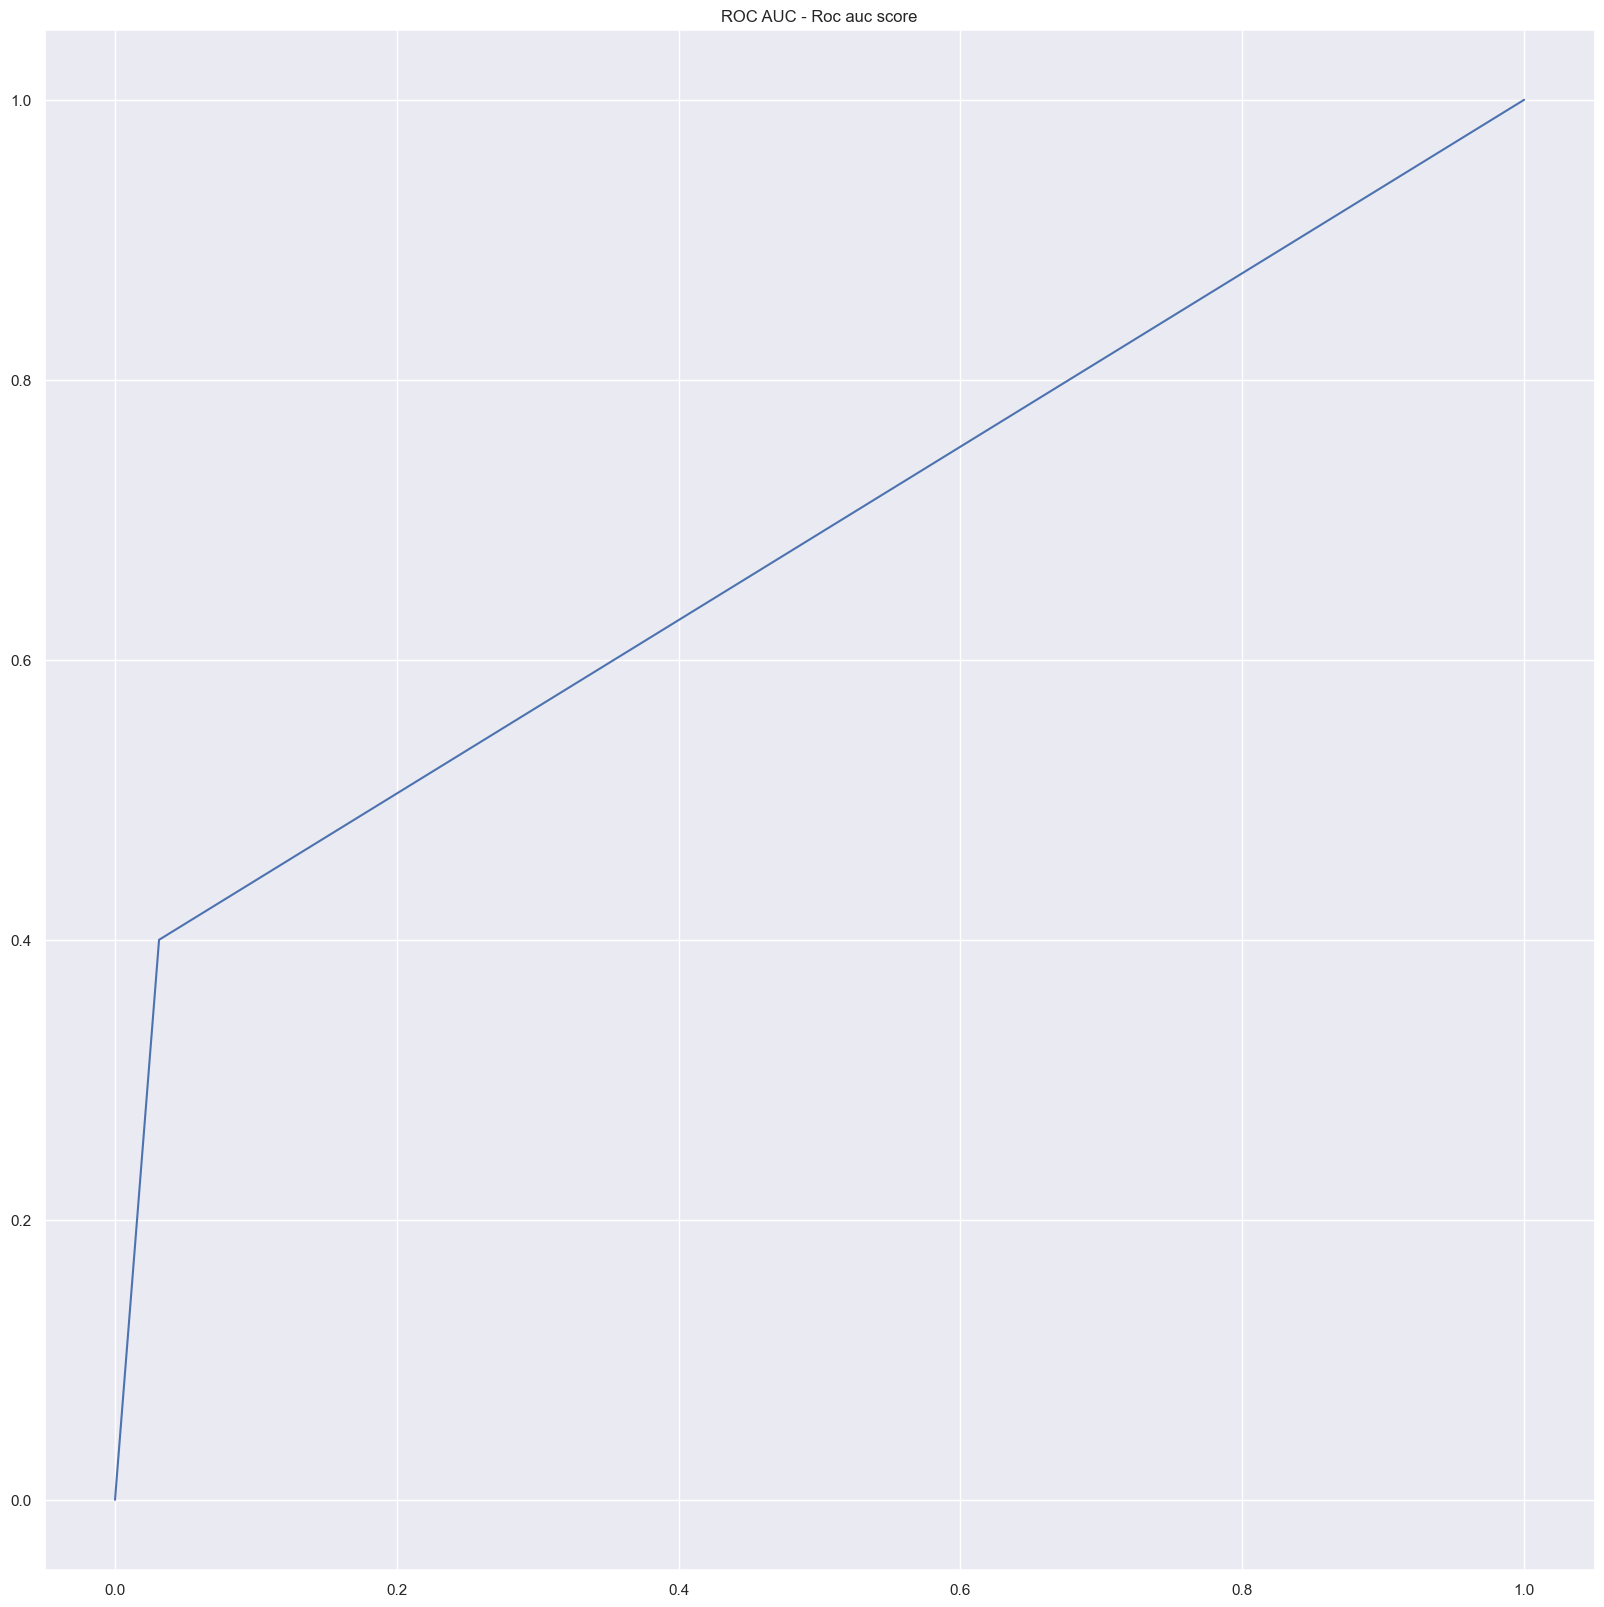

Модель - Логистическая регрессия
Accuracy - 0.8422330097087378
Precision - 0.34375
Recall - 0.09166666666666666
F1 - 0.14473684210526316
Roc auc score - 0.5309185606060606


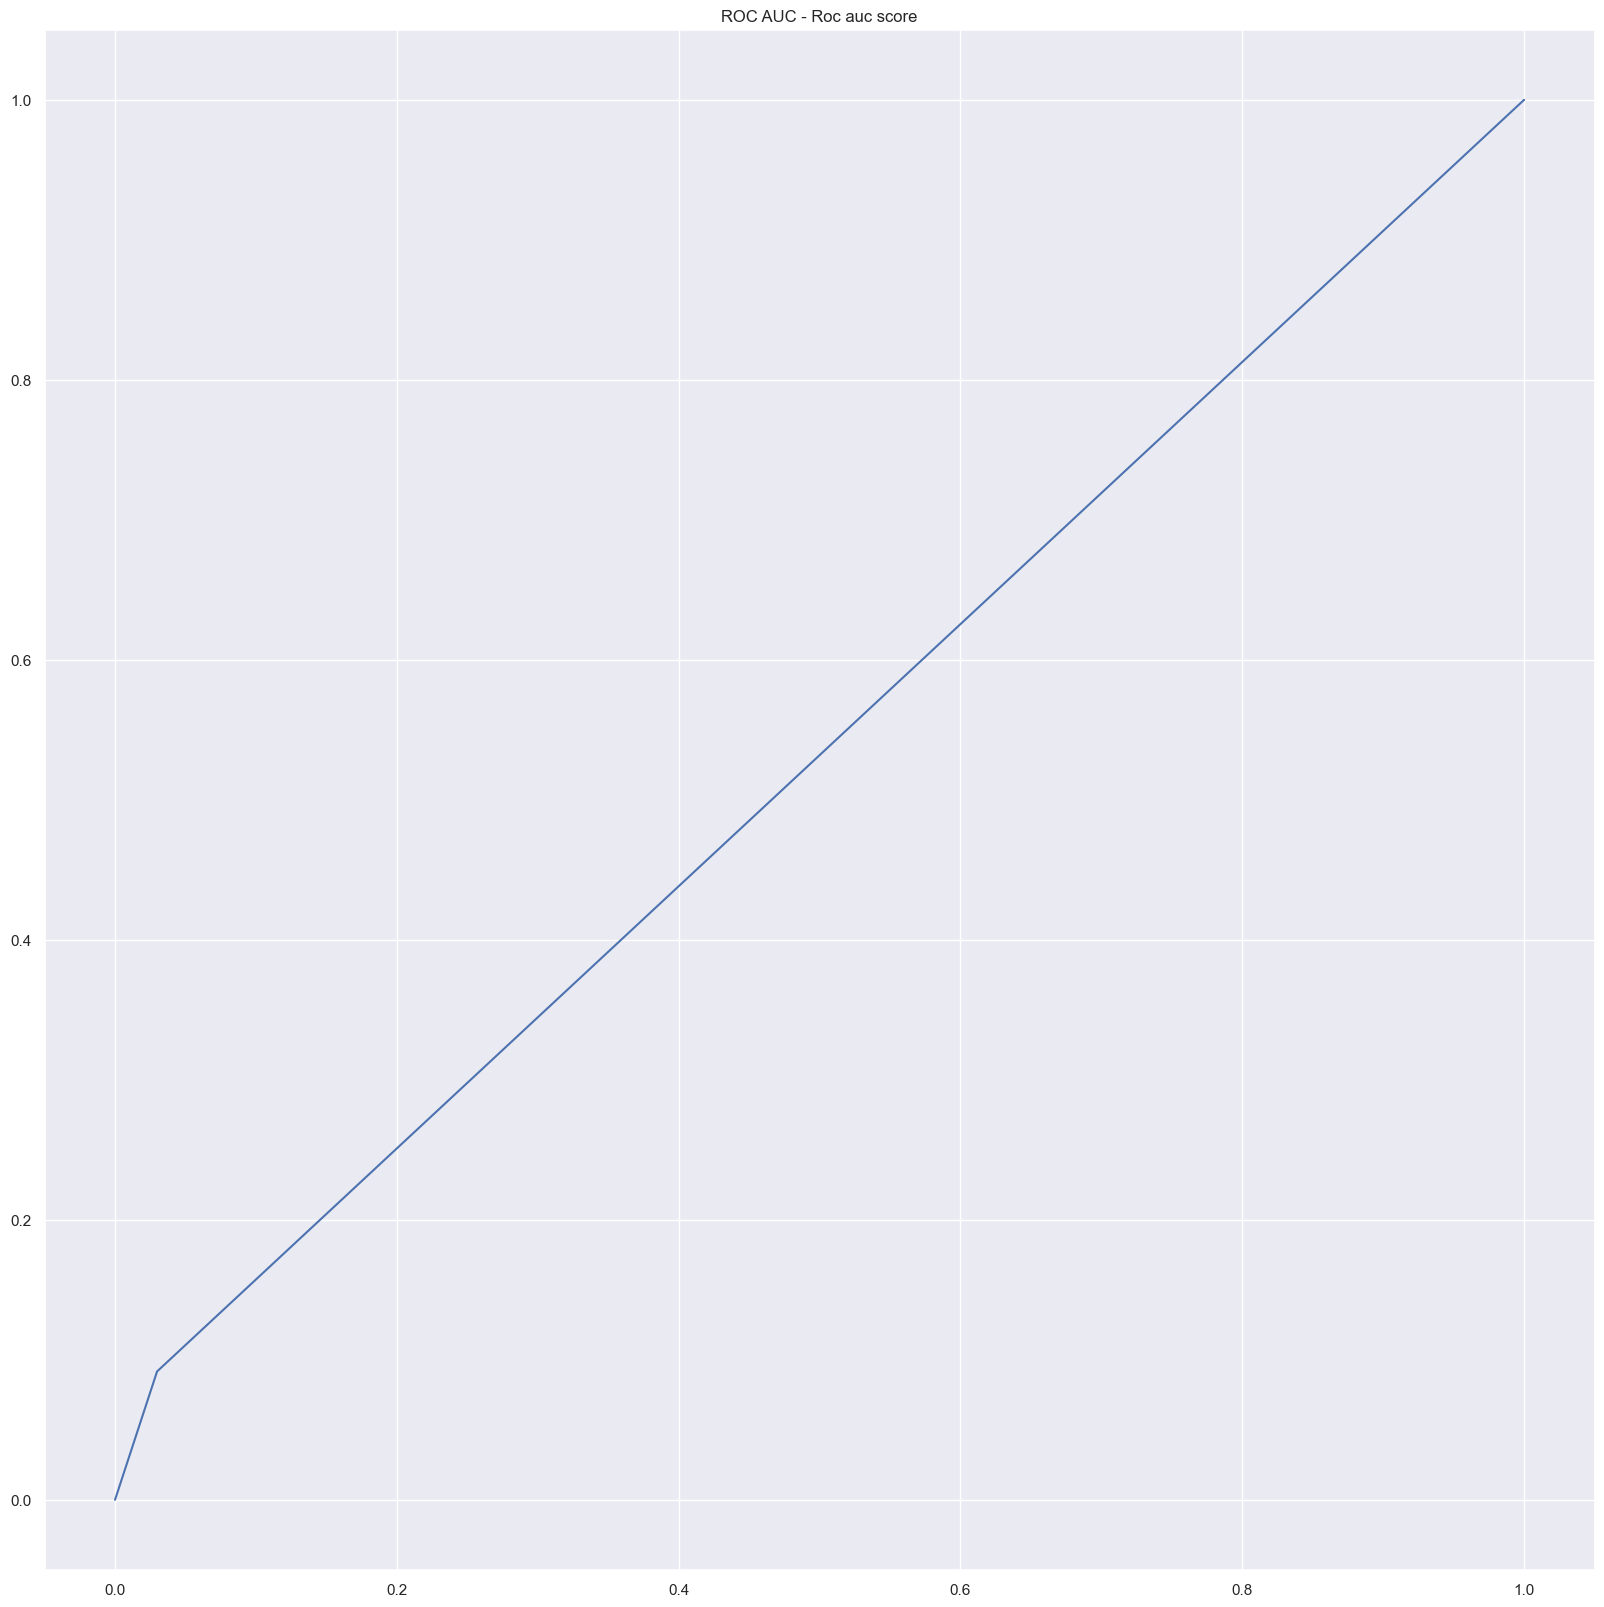

Модель - Метод опорных векторов
Accuracy - 0.8701456310679612
Precision - 0.6382978723404256
Recall - 0.25
F1 - 0.3592814371257485
Roc auc score - 0.6129261363636364


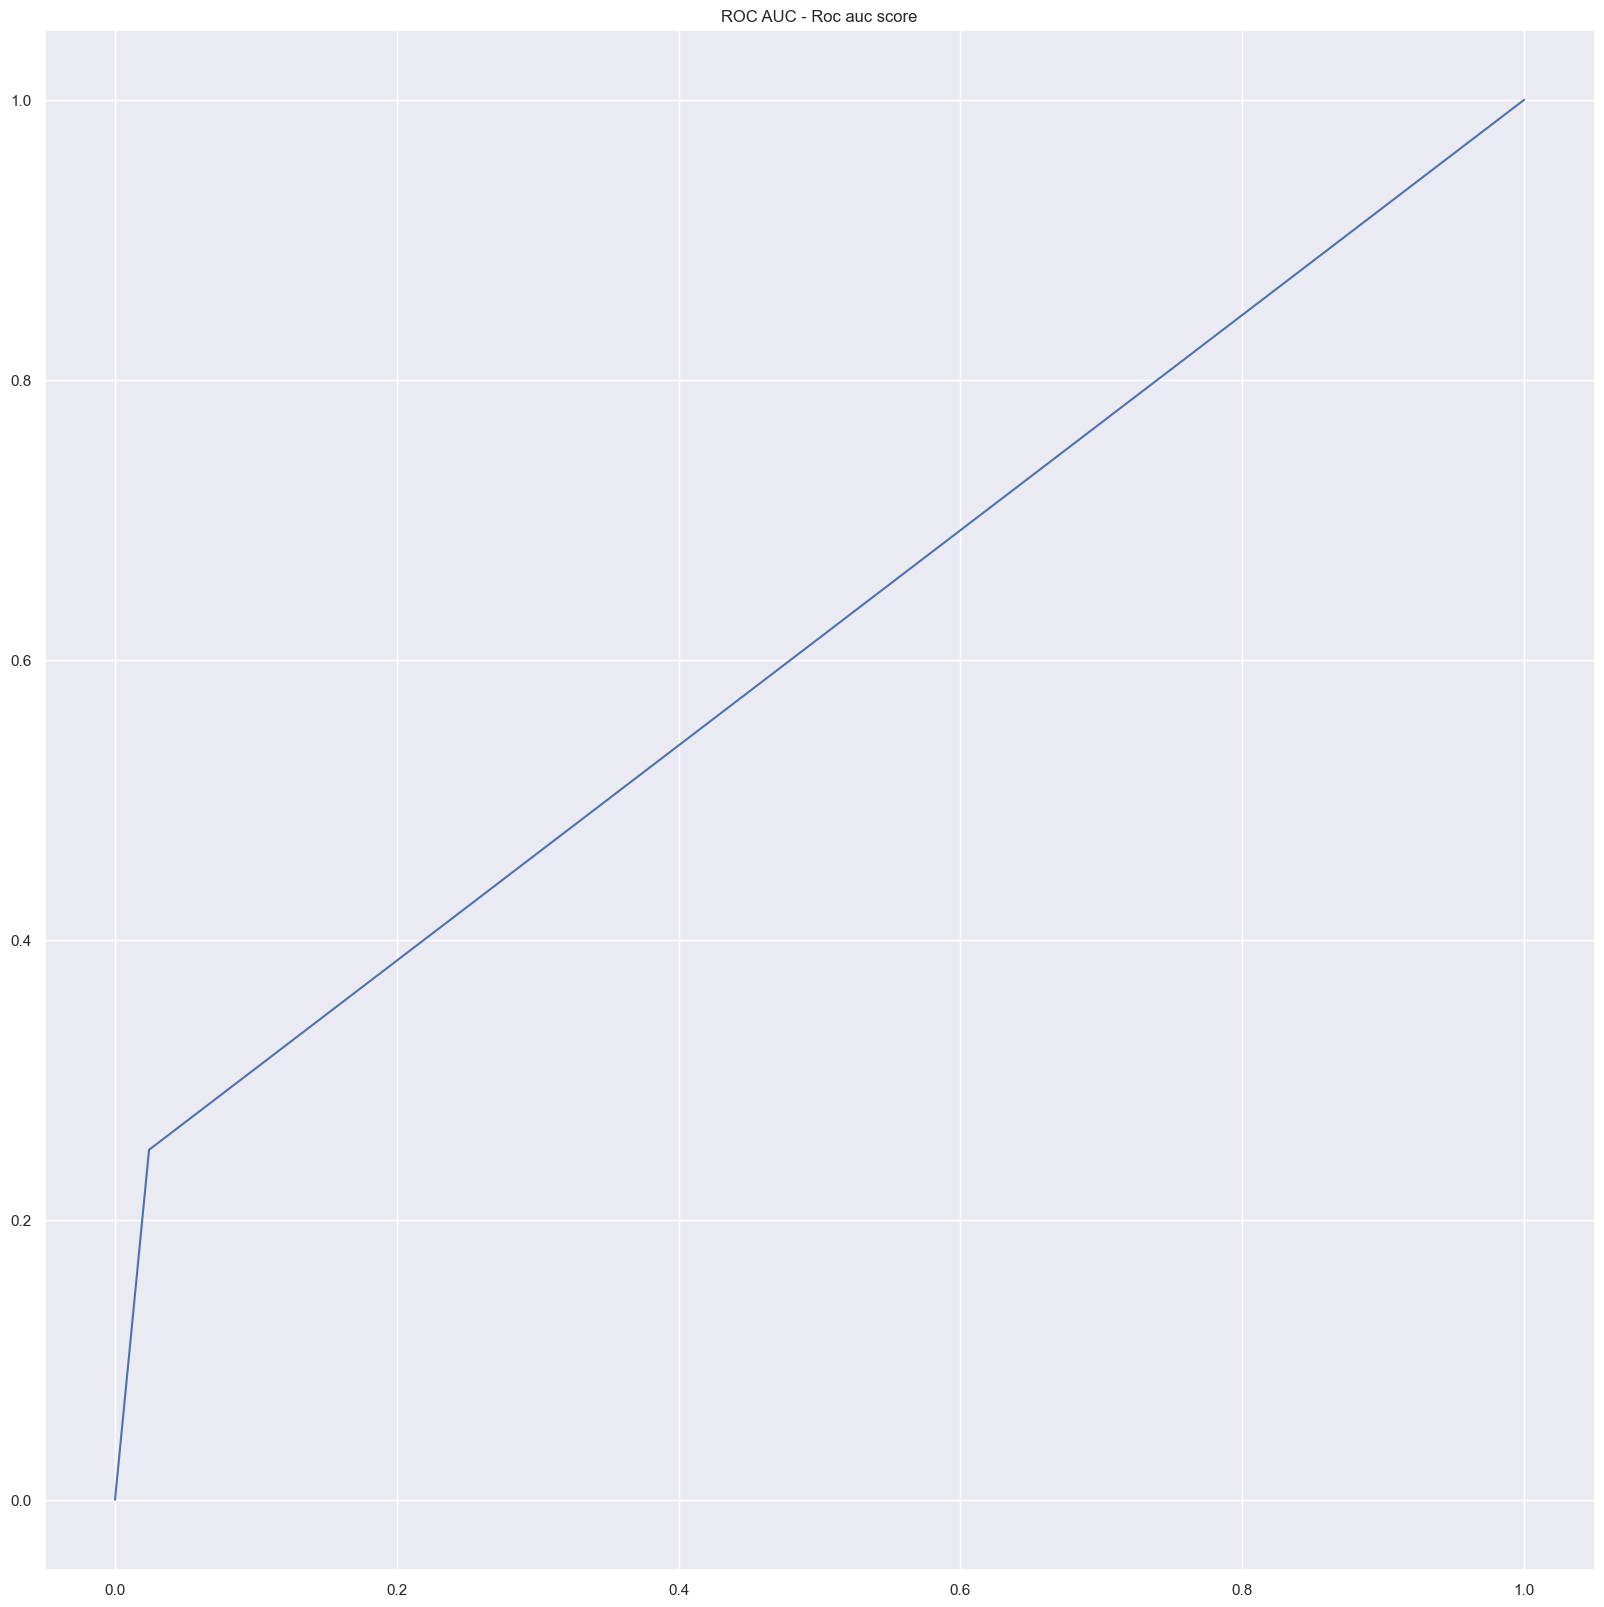

In [22]:
best_models = get_best_models(models_data, x_train, y_train)
for name, model in best_models.items():
    predicted = model.predict(x_test)
    print(f"Модель - {name}")
    metrics = get_metrics(y_test, predicted)
    methods_and_scores['Удаление столбцов исходя из корреляции'] = metrics
    for name, value in metrics.items():
        print(f"{name} - {value}")
    create_roc_curve(y_test, predicted, name=name)

# Отбор информативных признаков

Отбор признаков методом обертки

In [23]:

SELECTED_FEATURES = 6


estimator = LinearSVC()
selector = RFE(estimator, n_features_to_select=6, step=1)
selector = selector.fit(dataframe.drop(columns = OUTPUT_COLUMN), dataframe[OUTPUT_COLUMN])
selected_columns = list(selector.get_feature_names_out())
print(selected_columns)

['Total day minutes', 'Total day charge', 'Total eve minutes', 'Total intl charge', 'Customer service calls', 'International plan_Yes']


In [24]:
x_train, x_test, y_train, y_test = train_test_split(dataframe[selected_columns], dataframe[OUTPUT_COLUMN])

Модель - К-ближайших соседей
Accuracy - 0.8956310679611651
Precision - 0.8181818181818182
Recall - 0.4666666666666667
F1 - 0.5943396226415094
Roc auc score - 0.7231736816642479


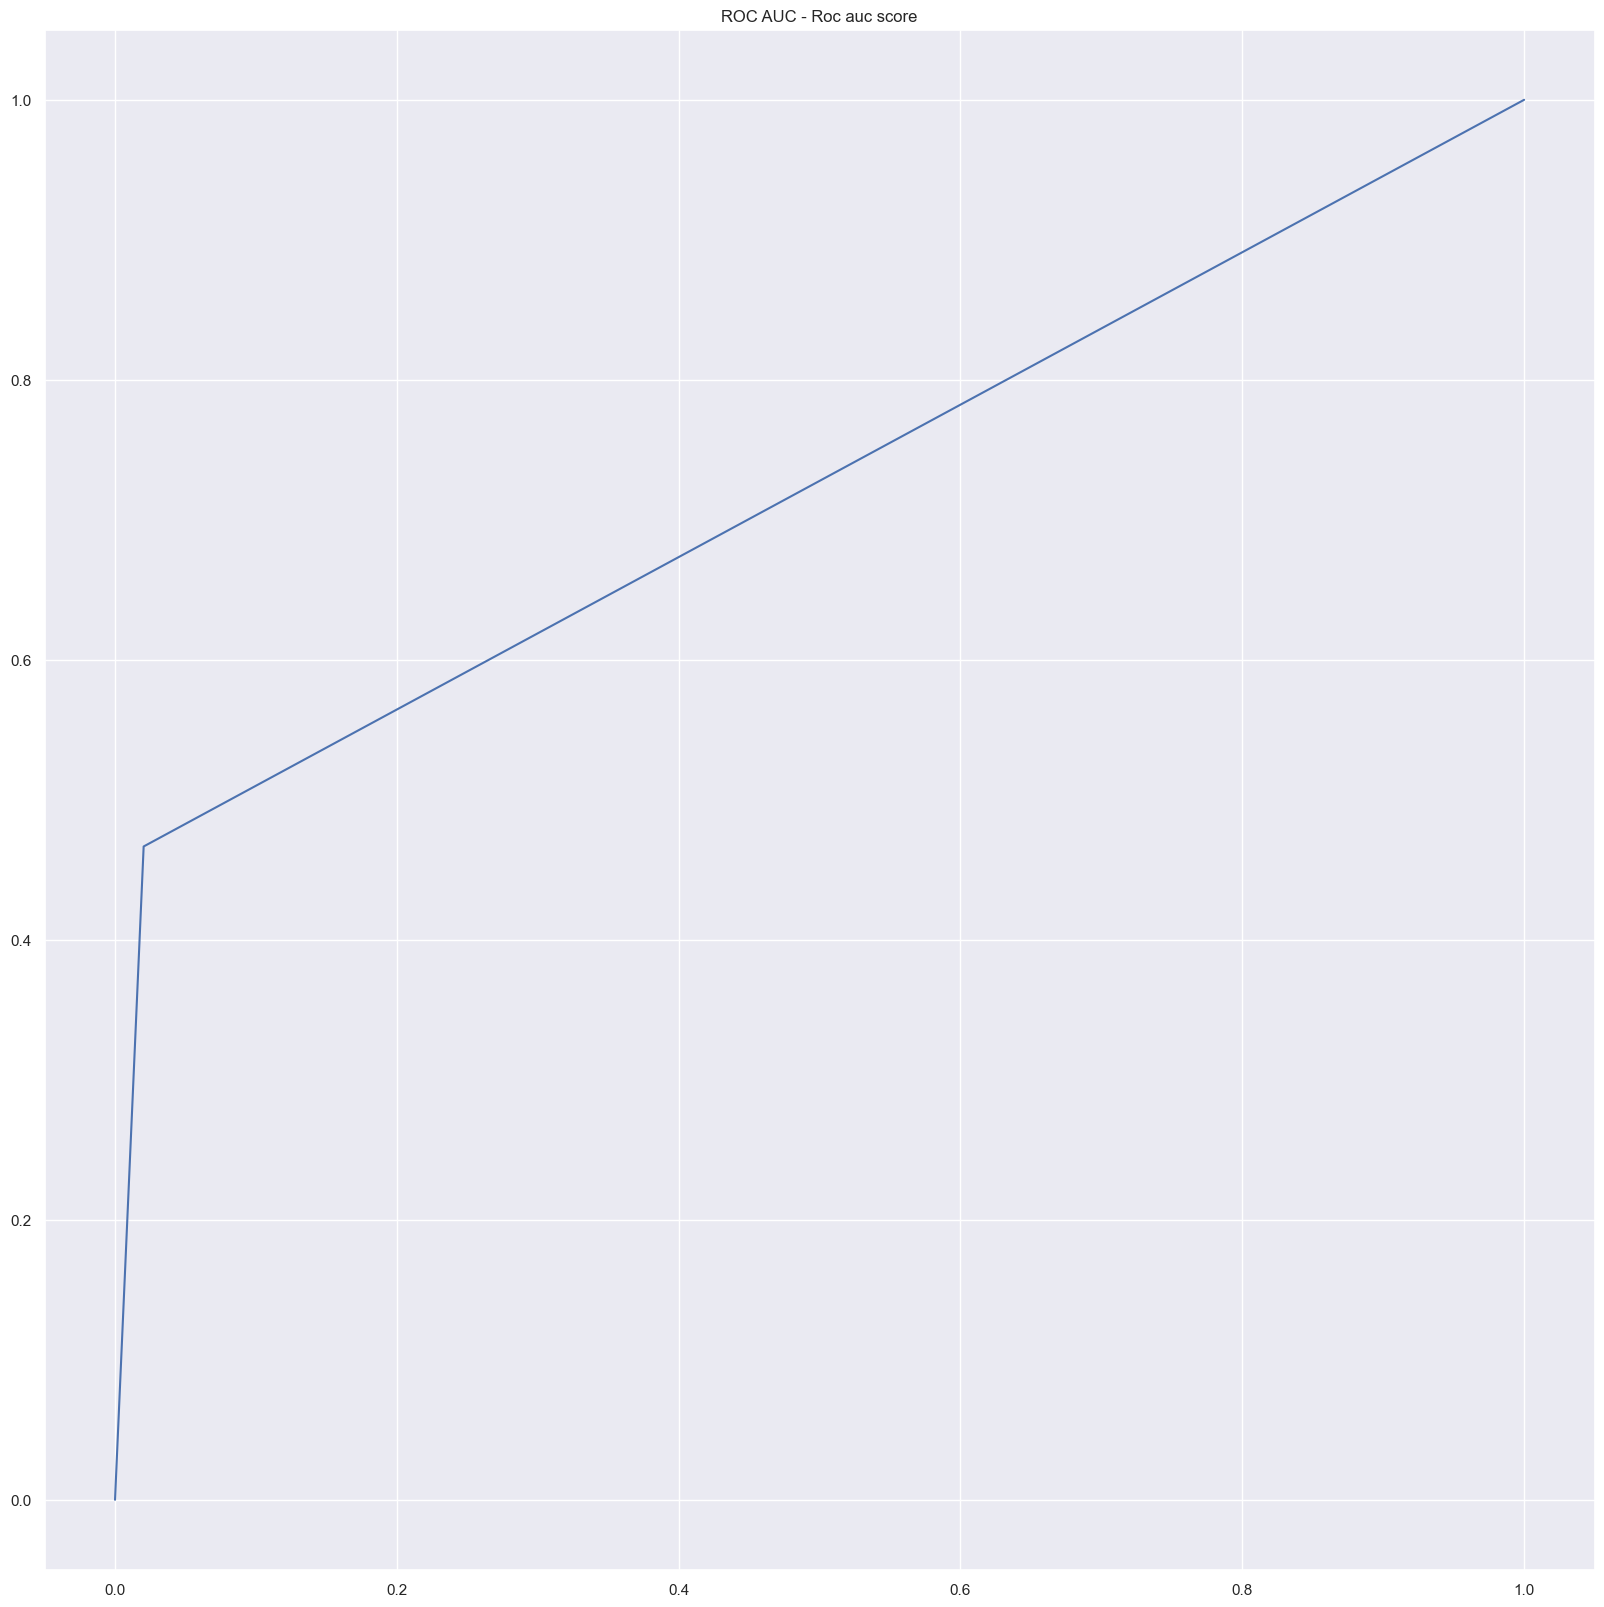

Модель - Логистическая регрессия
Accuracy - 0.8349514563106796
Precision - 0.4827586206896552
Recall - 0.1037037037037037
F1 - 0.17073170731707318
Roc auc score - 0.5409665107778314


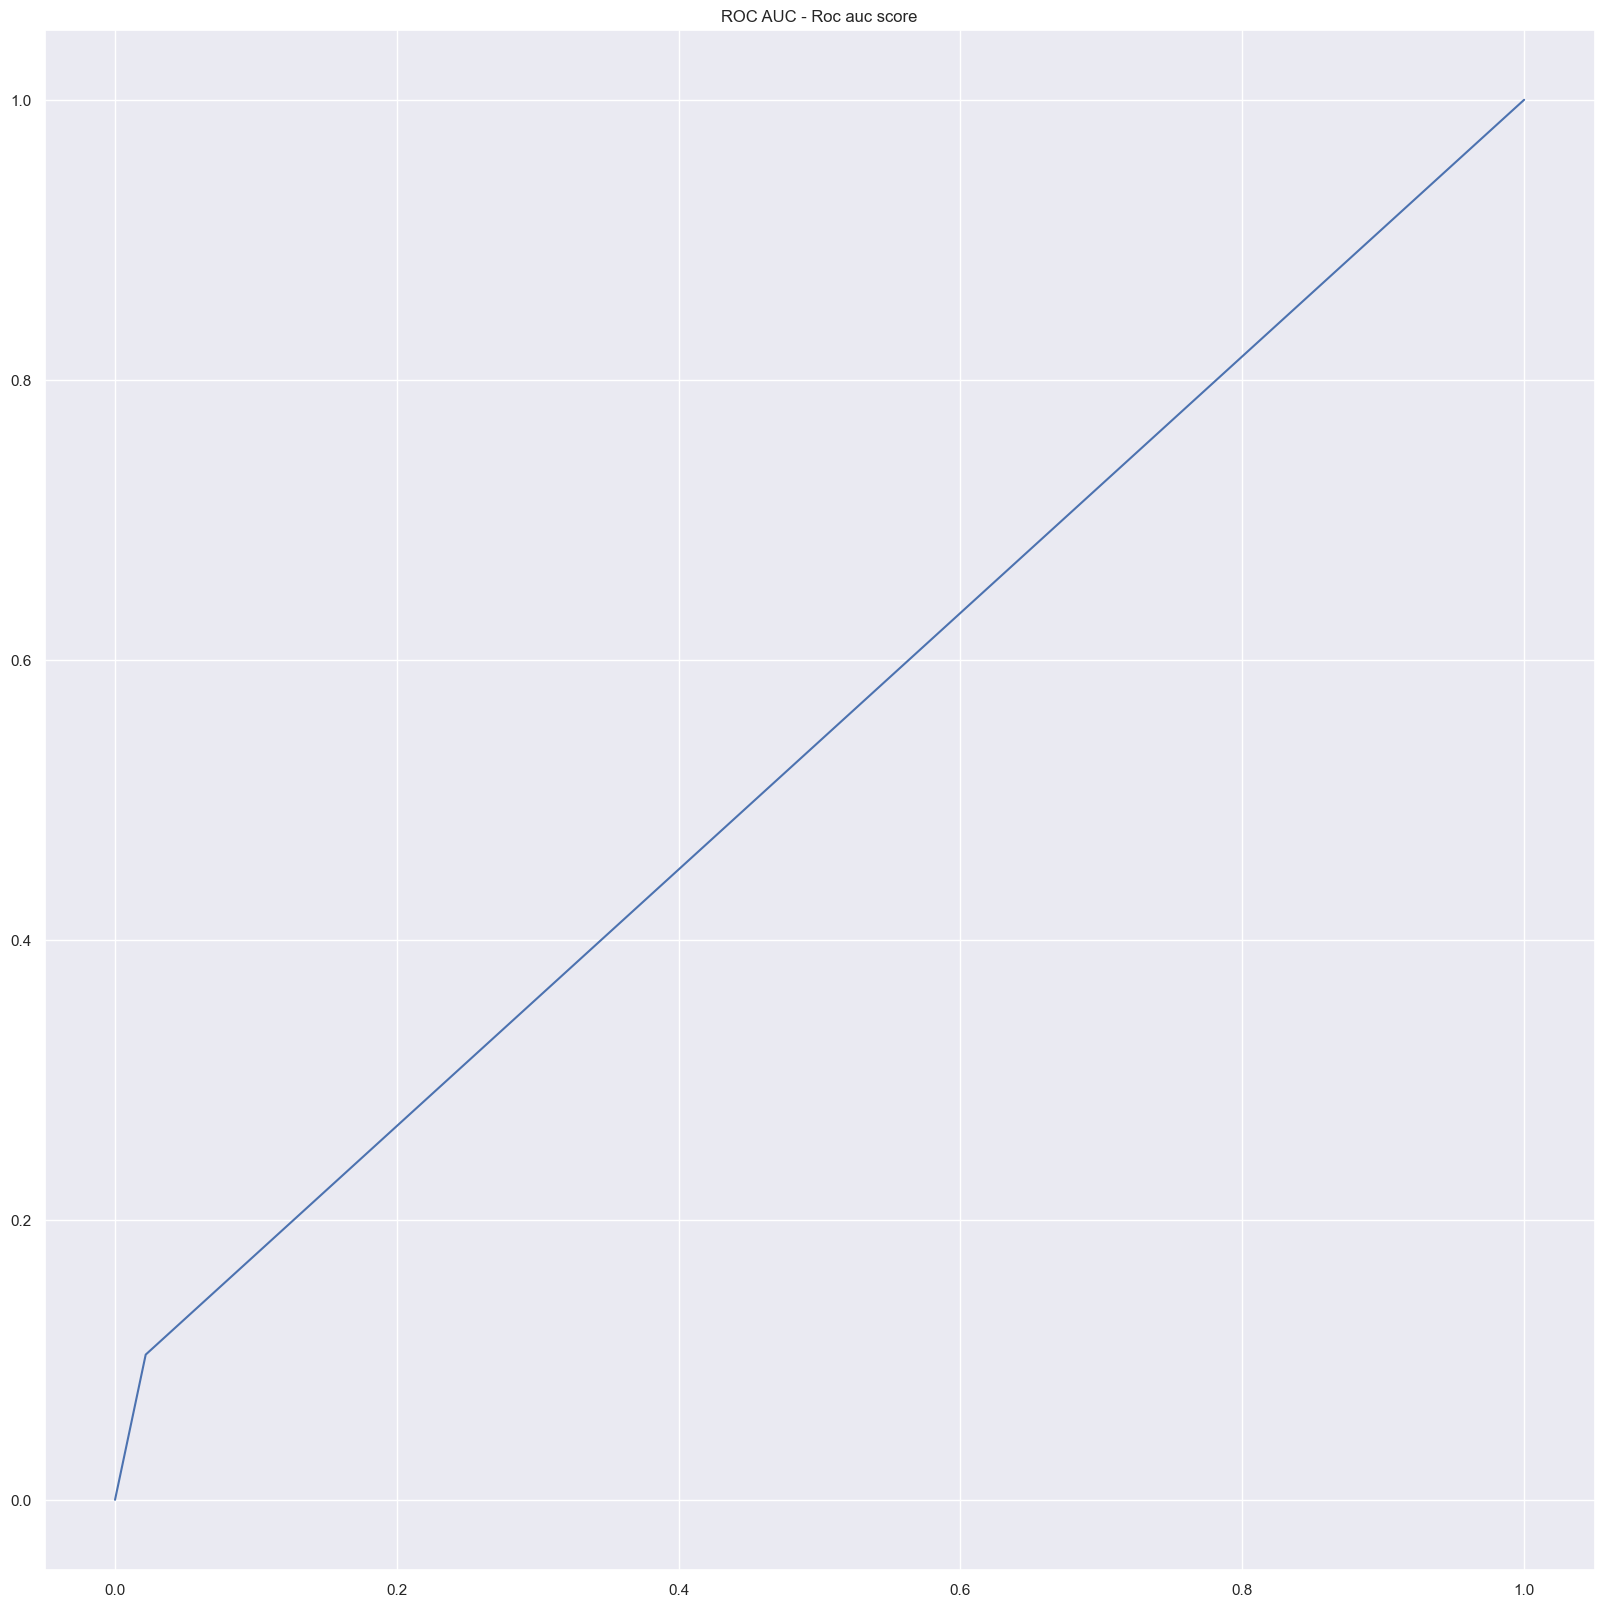

Модель - Метод опорных векторов
Accuracy - 0.8919902912621359
Precision - 0.859375
Recall - 0.4074074074074074
F1 - 0.5527638190954773
Roc auc score - 0.6971724990592915


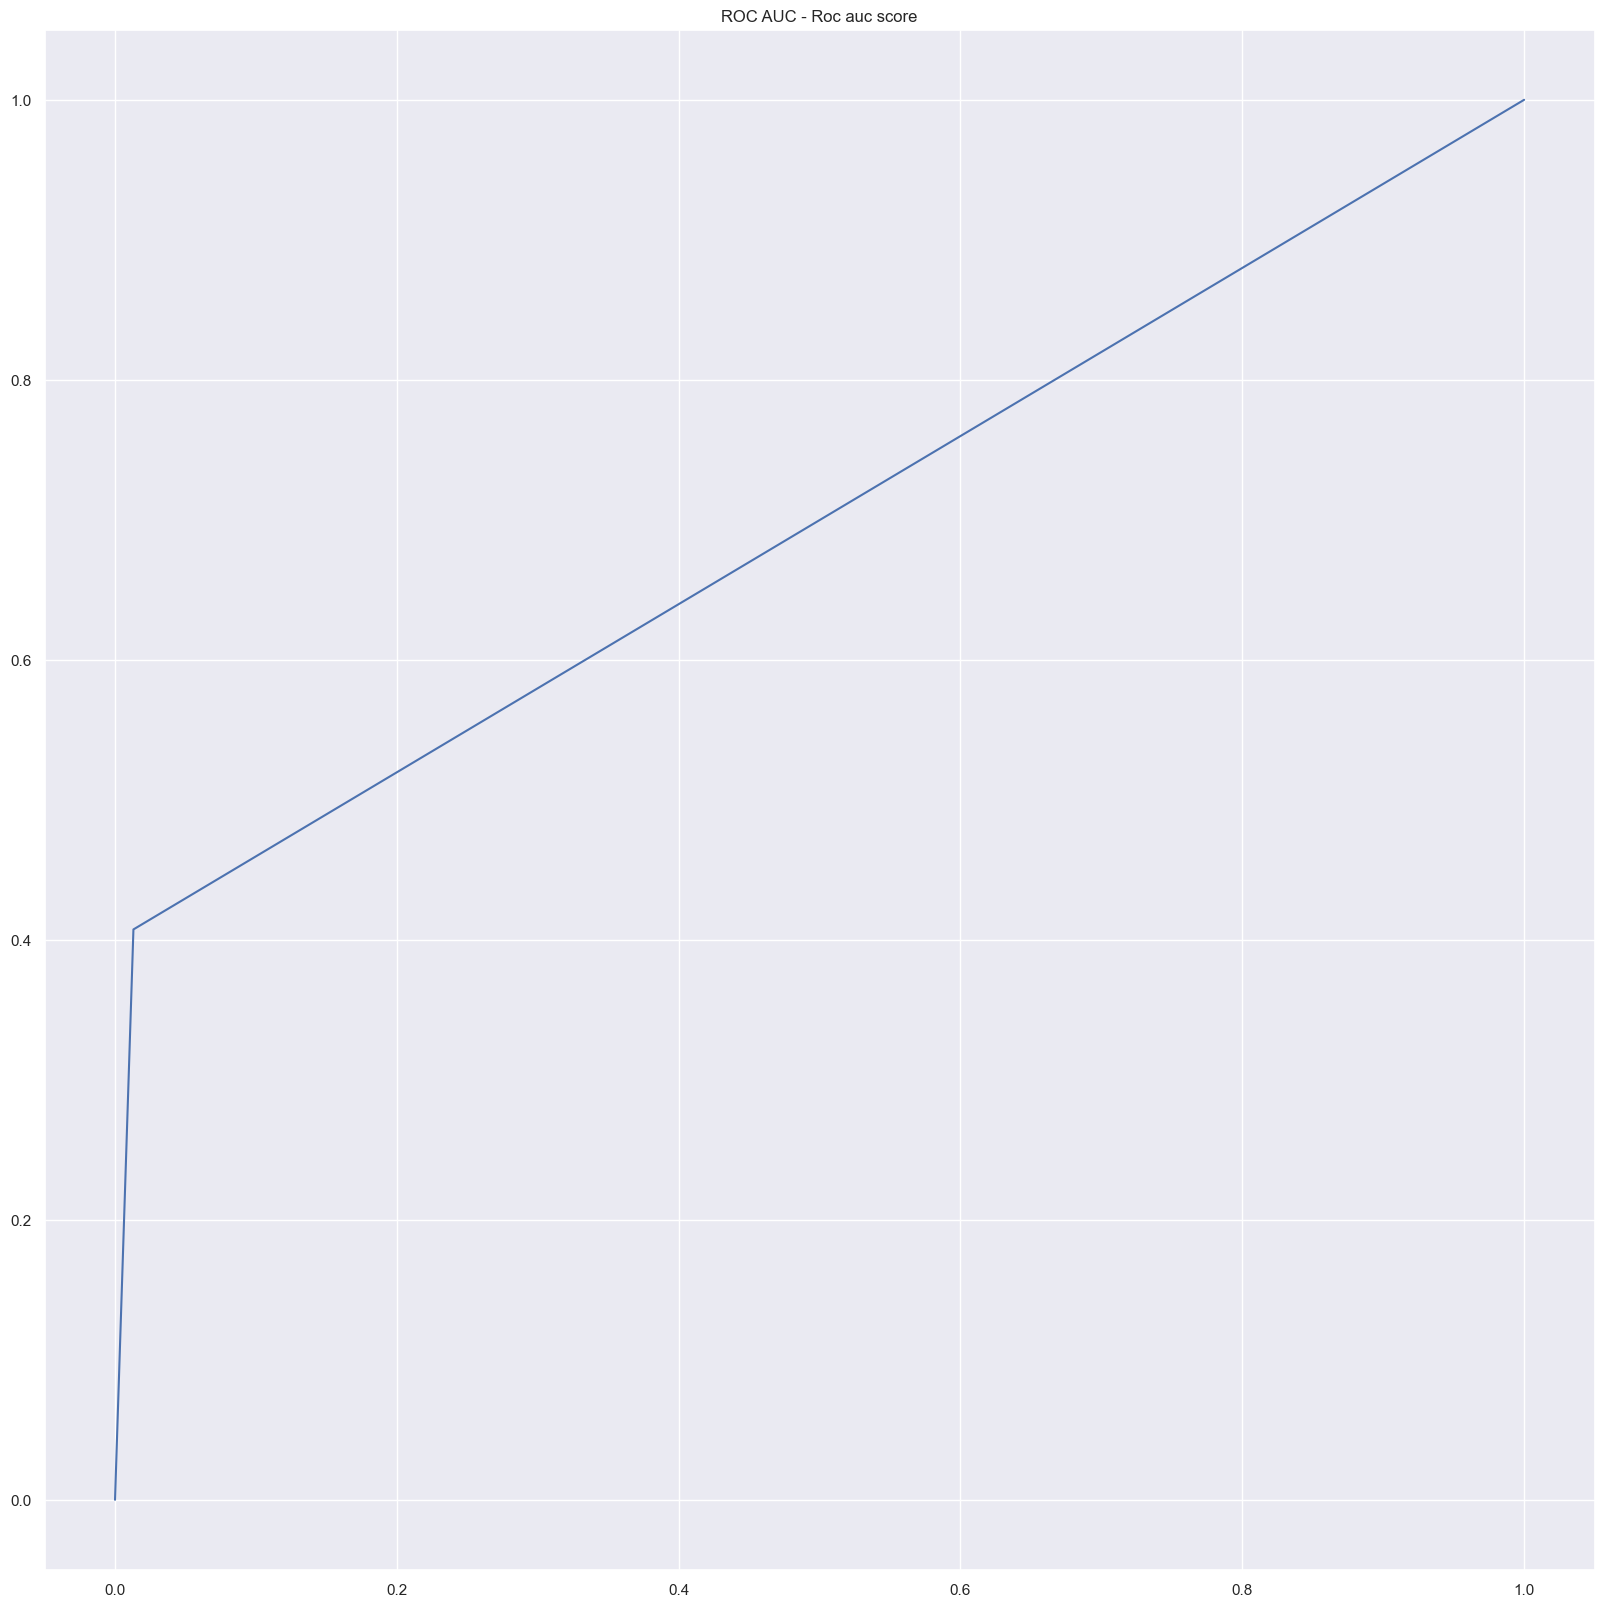

In [25]:
best_models = get_best_models(models_data, x_train, y_train)
for name, model in best_models.items():
    predicted = model.predict(x_test)
    print(f"Модель - {name}")
    metrics = get_metrics(y_test, predicted)
    methods_and_scores['Метод обертки'] = metrics
    for name, value in metrics.items():
        print(f"{name} - {value}")
    create_roc_curve(y_test, predicted, name=name)

Отбор признаков фильтрацией

In [26]:
SELECTED_FEATURES = 5
kbest = SelectKBest(k=SELECTED_FEATURES, score_func=chi2)
kbest_frame = kbest.fit_transform(dataframe.drop(columns=OUTPUT_COLUMN), dataframe[OUTPUT_COLUMN])
selected_columns = list(kbest.get_feature_names_out())
selected_columns

['Number vmail messages',
 'Total day minutes',
 'Customer service calls',
 'International plan_Yes',
 'Voice mail plan_Yes']

Модель - К-ближайших соседей
Accuracy - 0.9004854368932039
Precision - 0.7424242424242424
Recall - 0.4298245614035088
F1 - 0.5444444444444445
Roc auc score - 0.7029404497158389


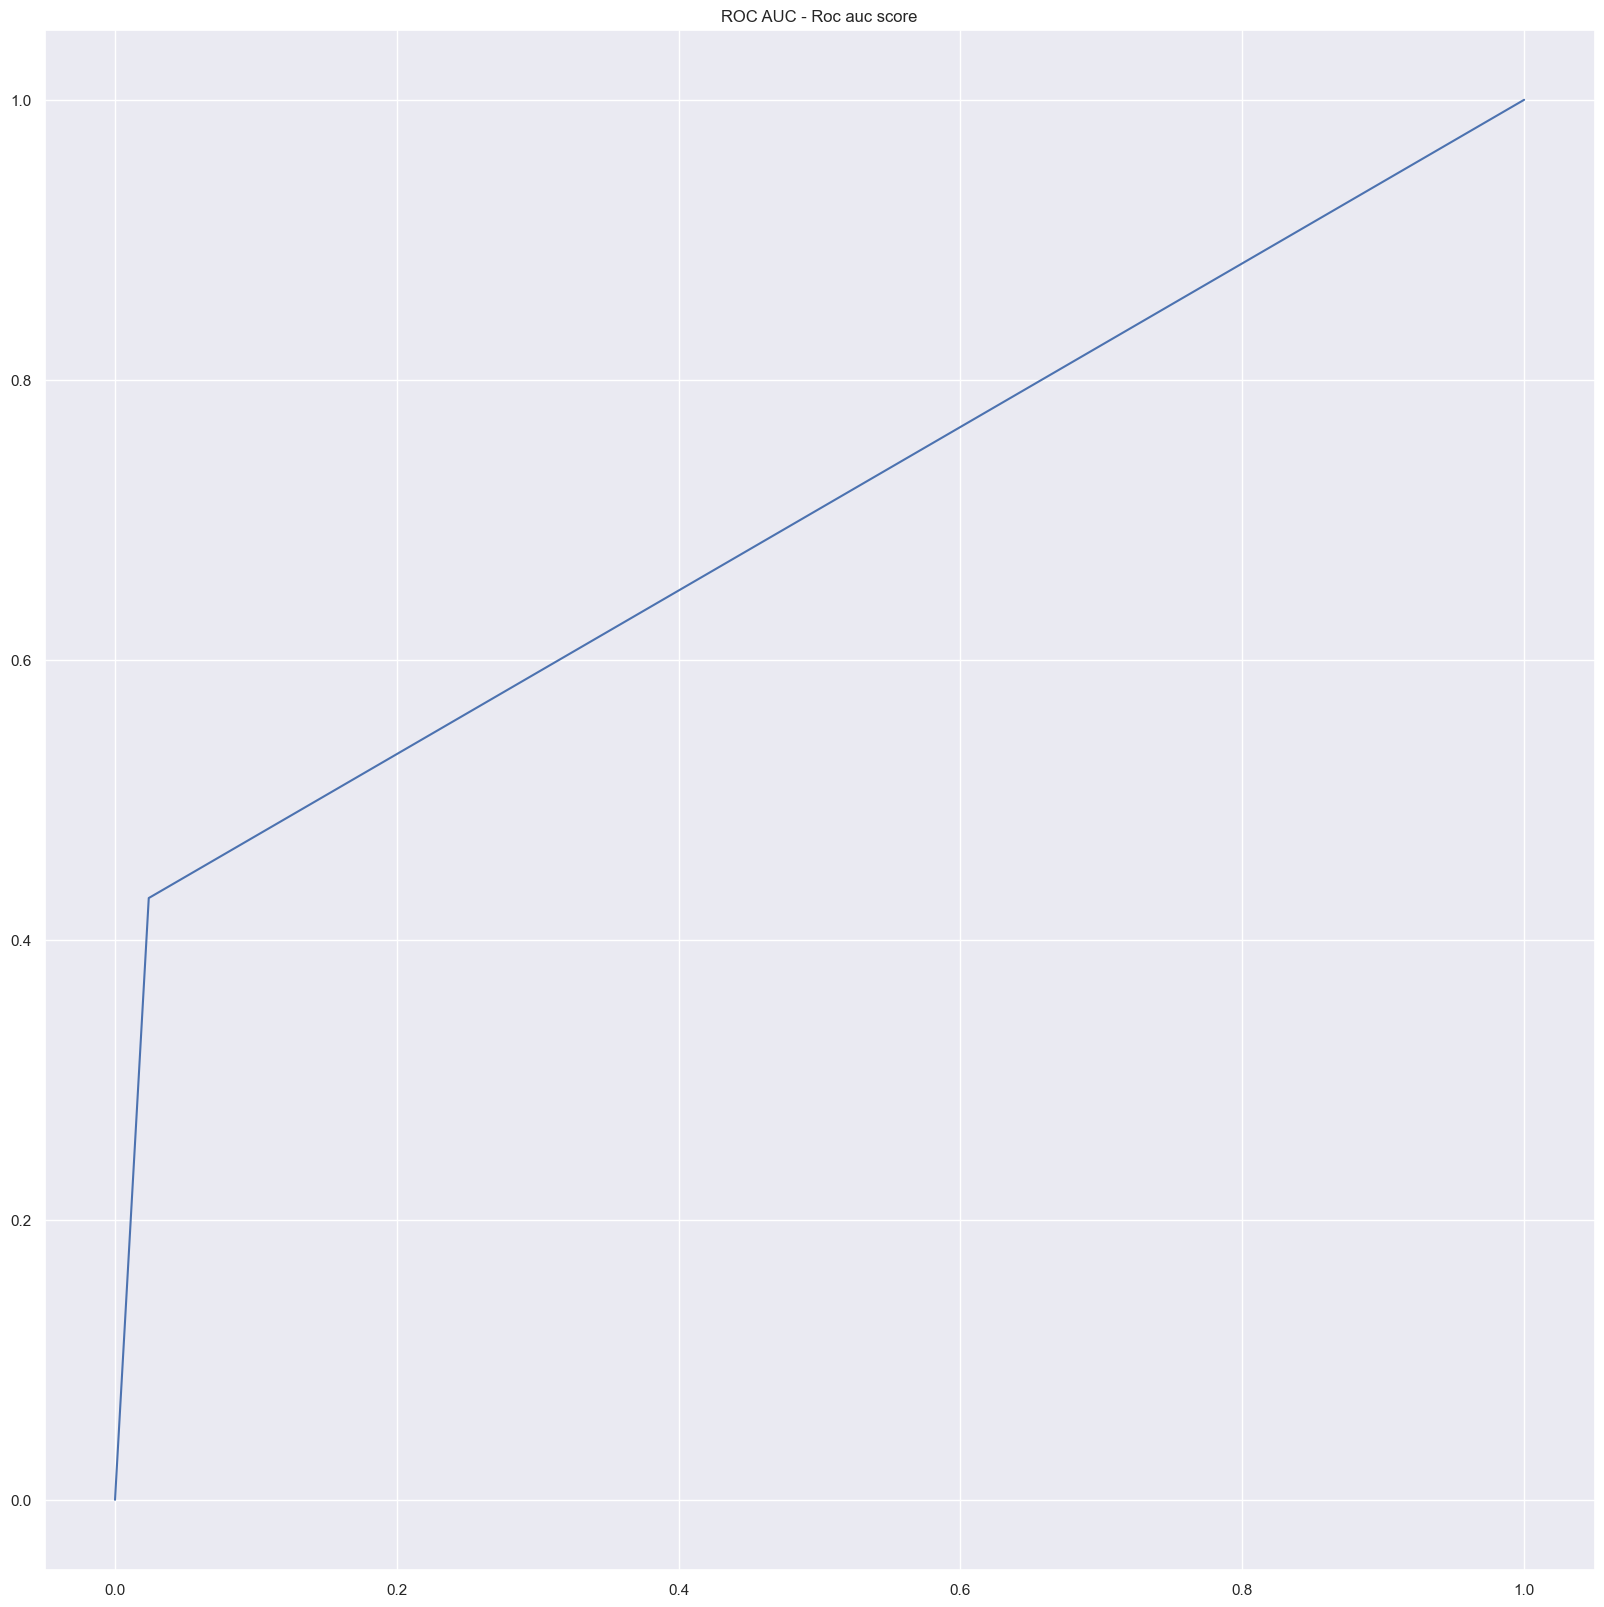

Модель - Логистическая регрессия
Accuracy - 0.8616504854368932
Precision - 0.5
Recall - 0.08771929824561403
F1 - 0.14925373134328357
Roc auc score - 0.5368173956016803


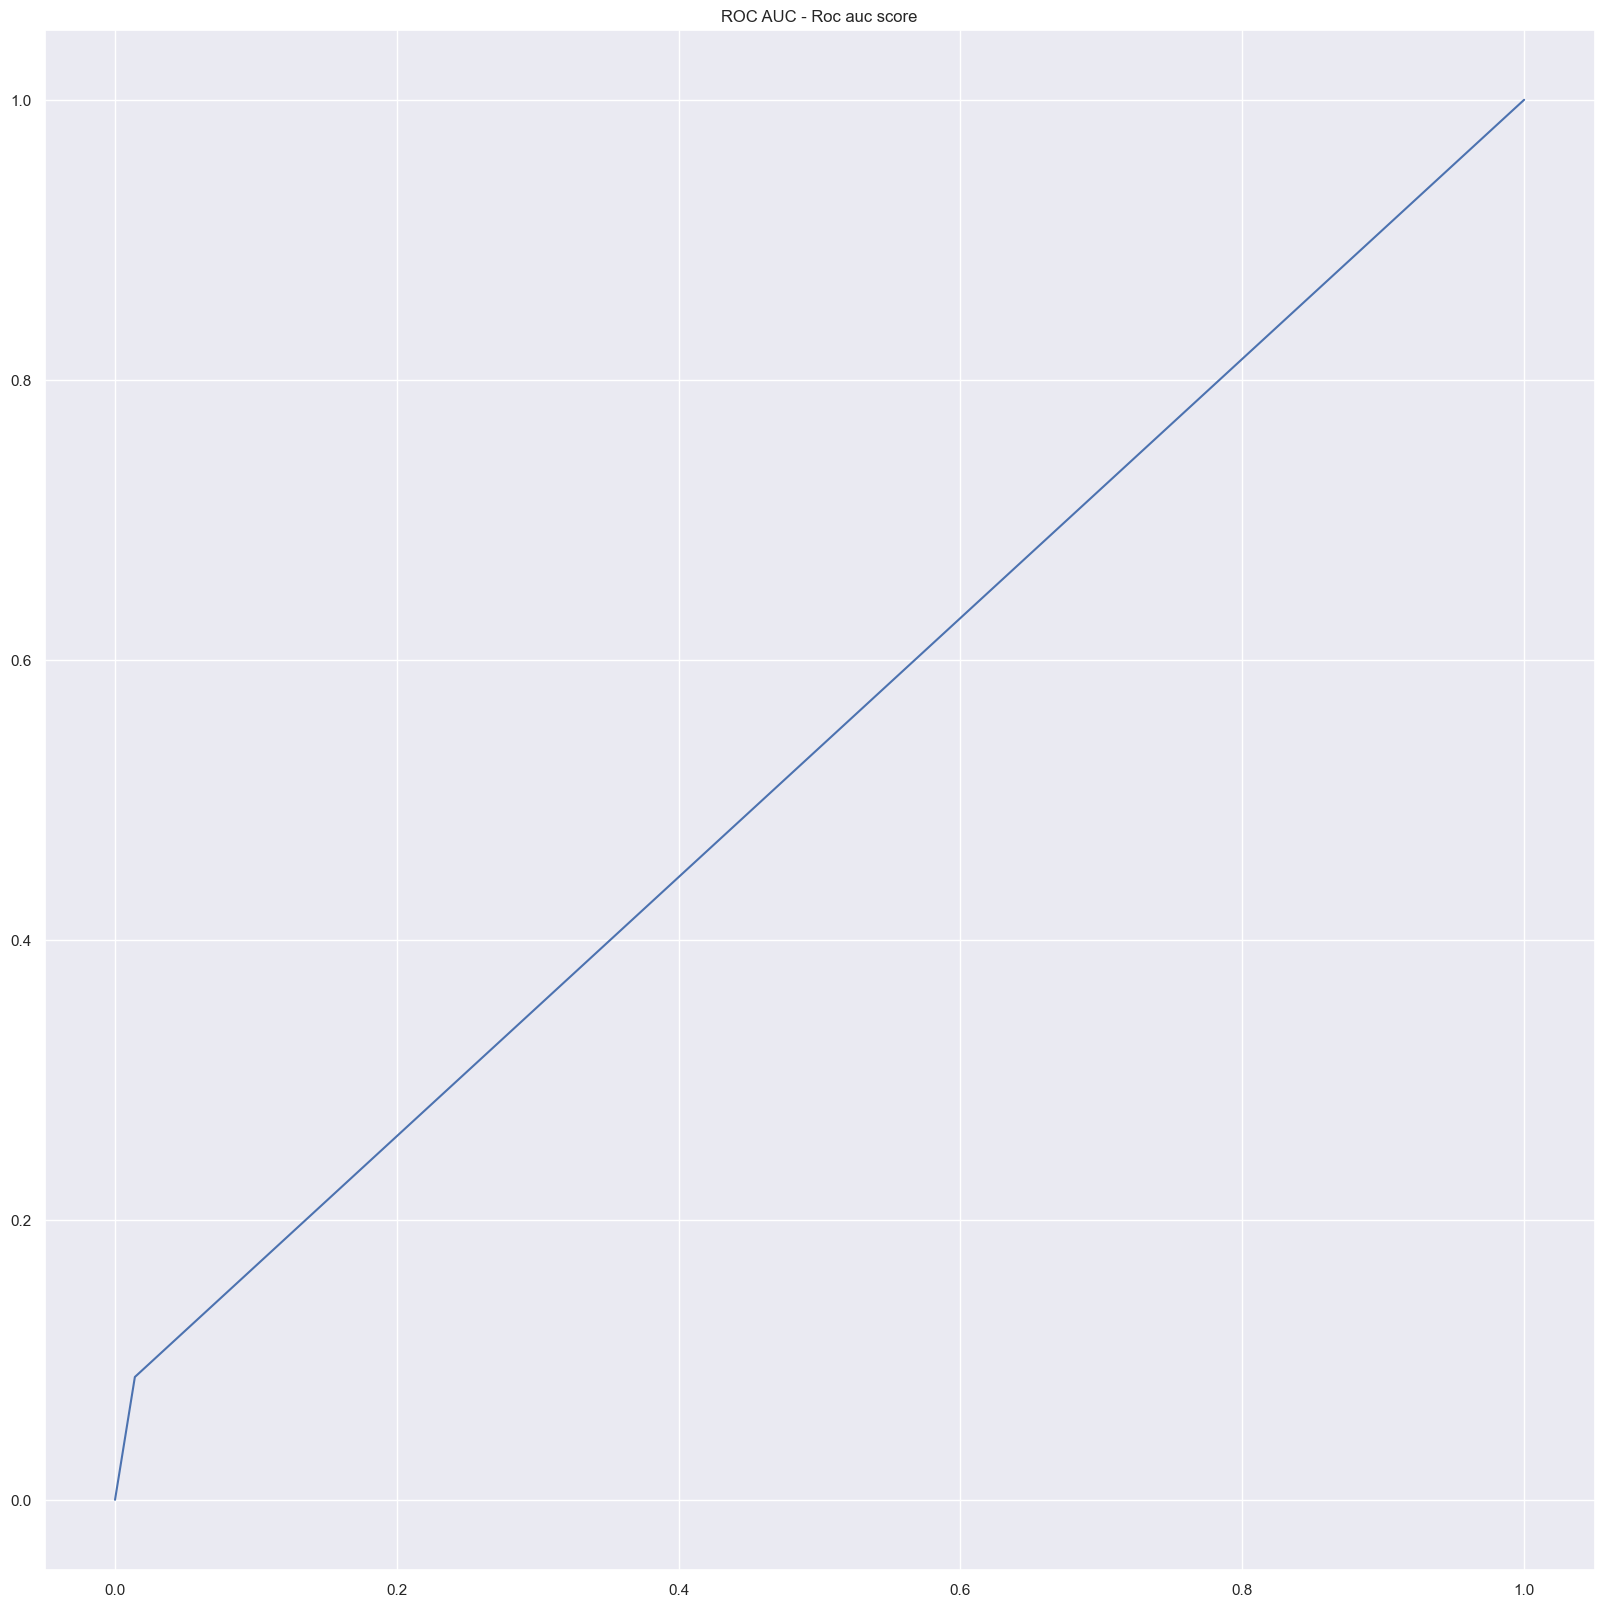

Модель - Метод опорных векторов
Accuracy - 0.8713592233009708
Precision - 0.5740740740740741
Recall - 0.2719298245614035
F1 - 0.369047619047619
Roc auc score - 0.6197677291821102


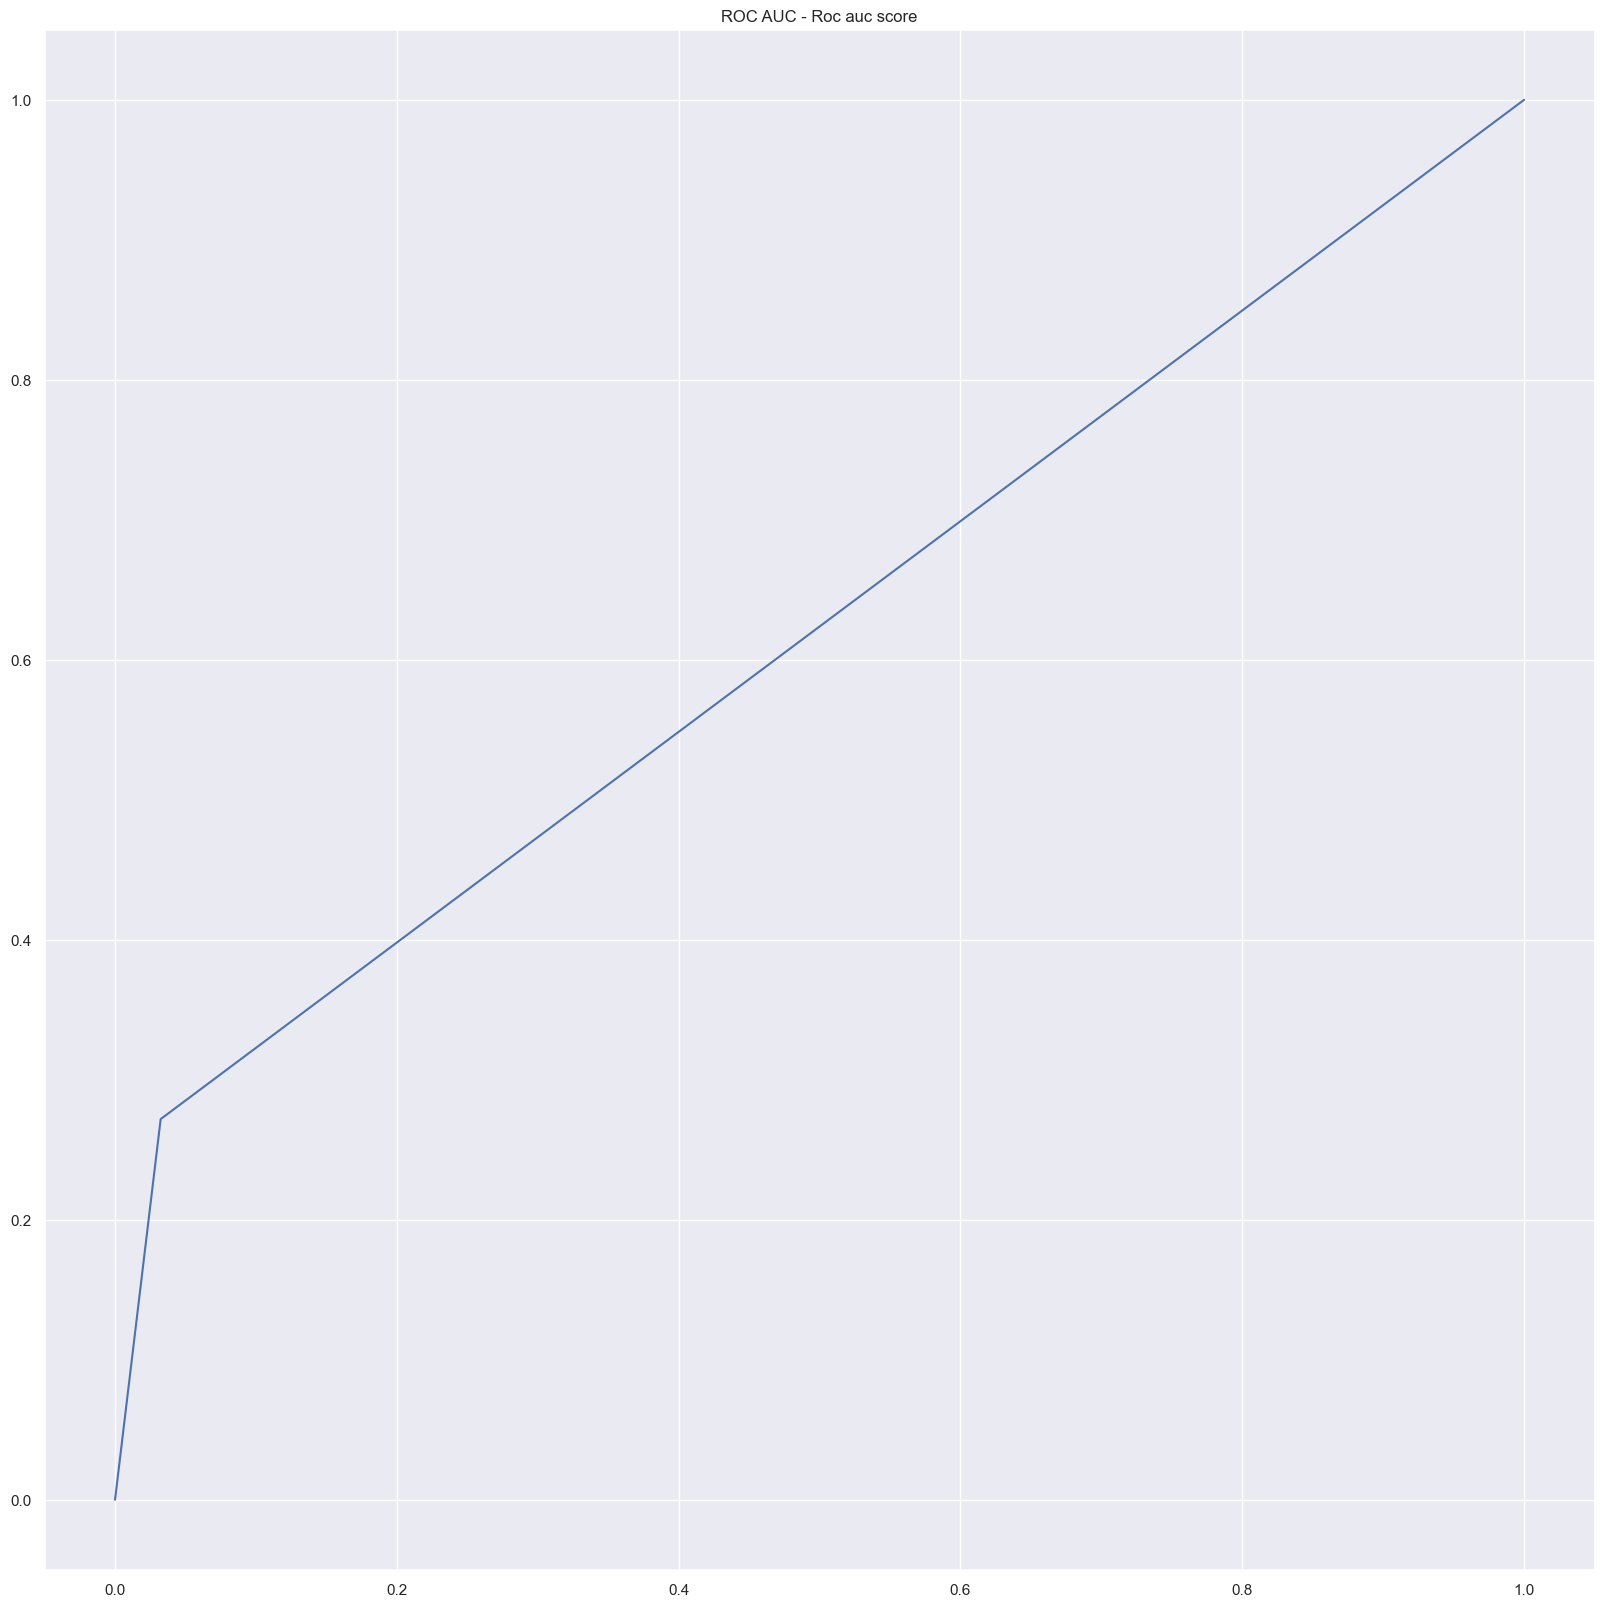

In [27]:
x_train, x_test, y_train, y_test = train_test_split(dataframe[selected_columns], dataframe[OUTPUT_COLUMN])
best_models = get_best_models(models_data, x_train, y_train)
for name, model in best_models.items():
    predicted = model.predict(x_test)
    print(f"Модель - {name}")
    metrics = get_metrics(y_test, predicted)
    methods_and_scores['Метод фильтрации'] = metrics
    for name, value in metrics.items():
        print(f"{name} - {value}")
    create_roc_curve(y_test, predicted, name=name)

Отбор признаков встроенными методами

In [28]:
model = Lasso(alpha=0.01)
model.fit(dataframe.drop(columns = OUTPUT_COLUMN), dataframe[OUTPUT_COLUMN])
selected_columns = dataframe.drop(columns = OUTPUT_COLUMN).columns[model.coef_ != 0]
selected_columns = list(selected_columns)
selected_columns

['Total day minutes',
 'Customer service calls',
 'International plan_Yes',
 'Voice mail plan_Yes']

Модель - К-ближайших соседей
Accuracy - 0.8883495145631068
Precision - 0.7352941176470589
Recall - 0.4032258064516129
F1 - 0.5208333333333333
Roc auc score - 0.6887557603686636


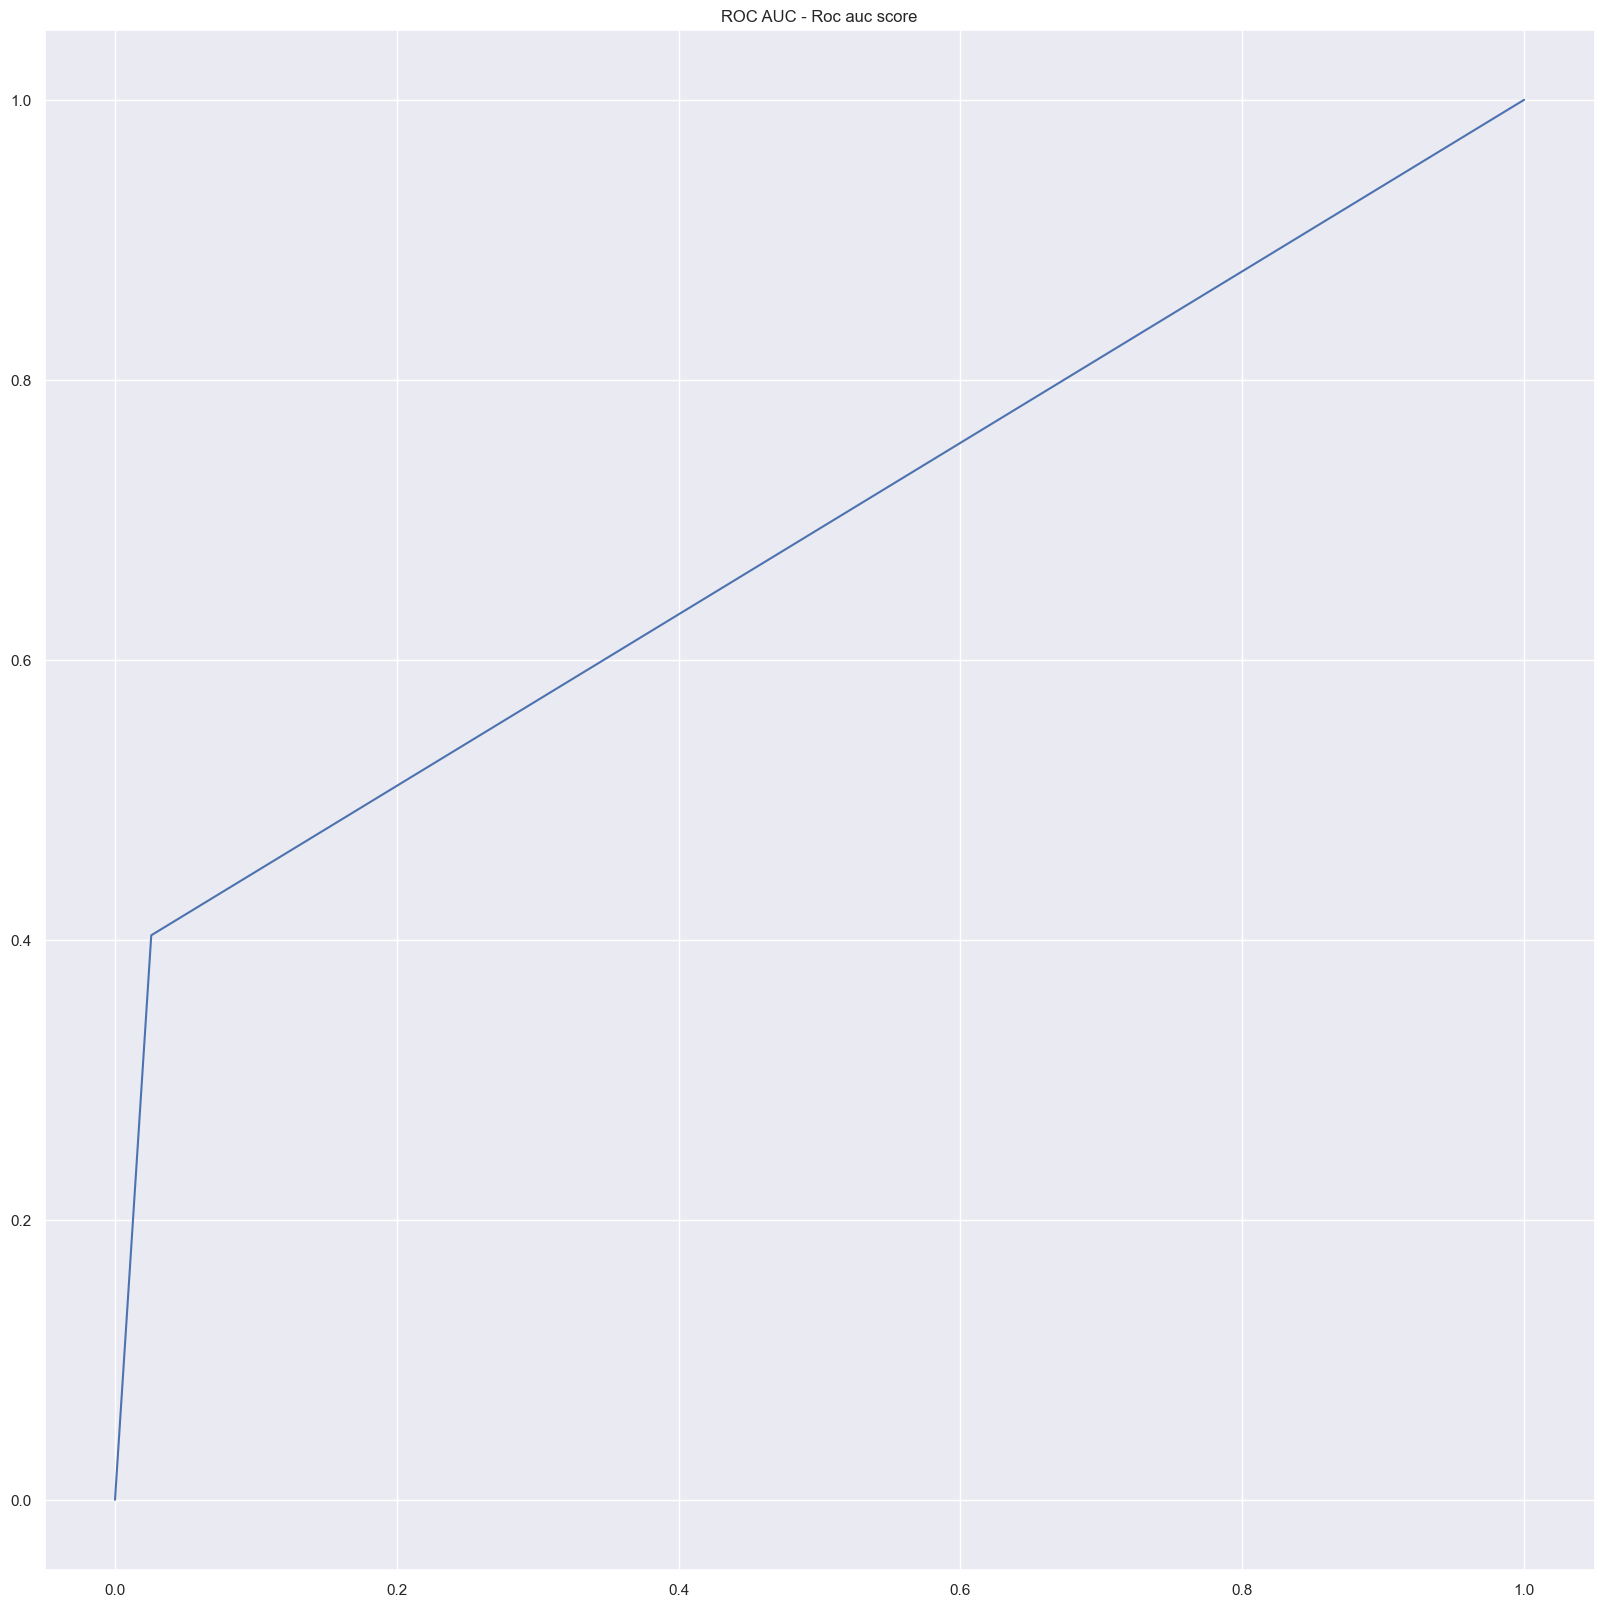

Модель - Логистическая регрессия
Accuracy - 0.8604368932038835
Precision - 0.68
Recall - 0.13709677419354838
F1 - 0.22818791946308725
Roc auc score - 0.5628341013824886


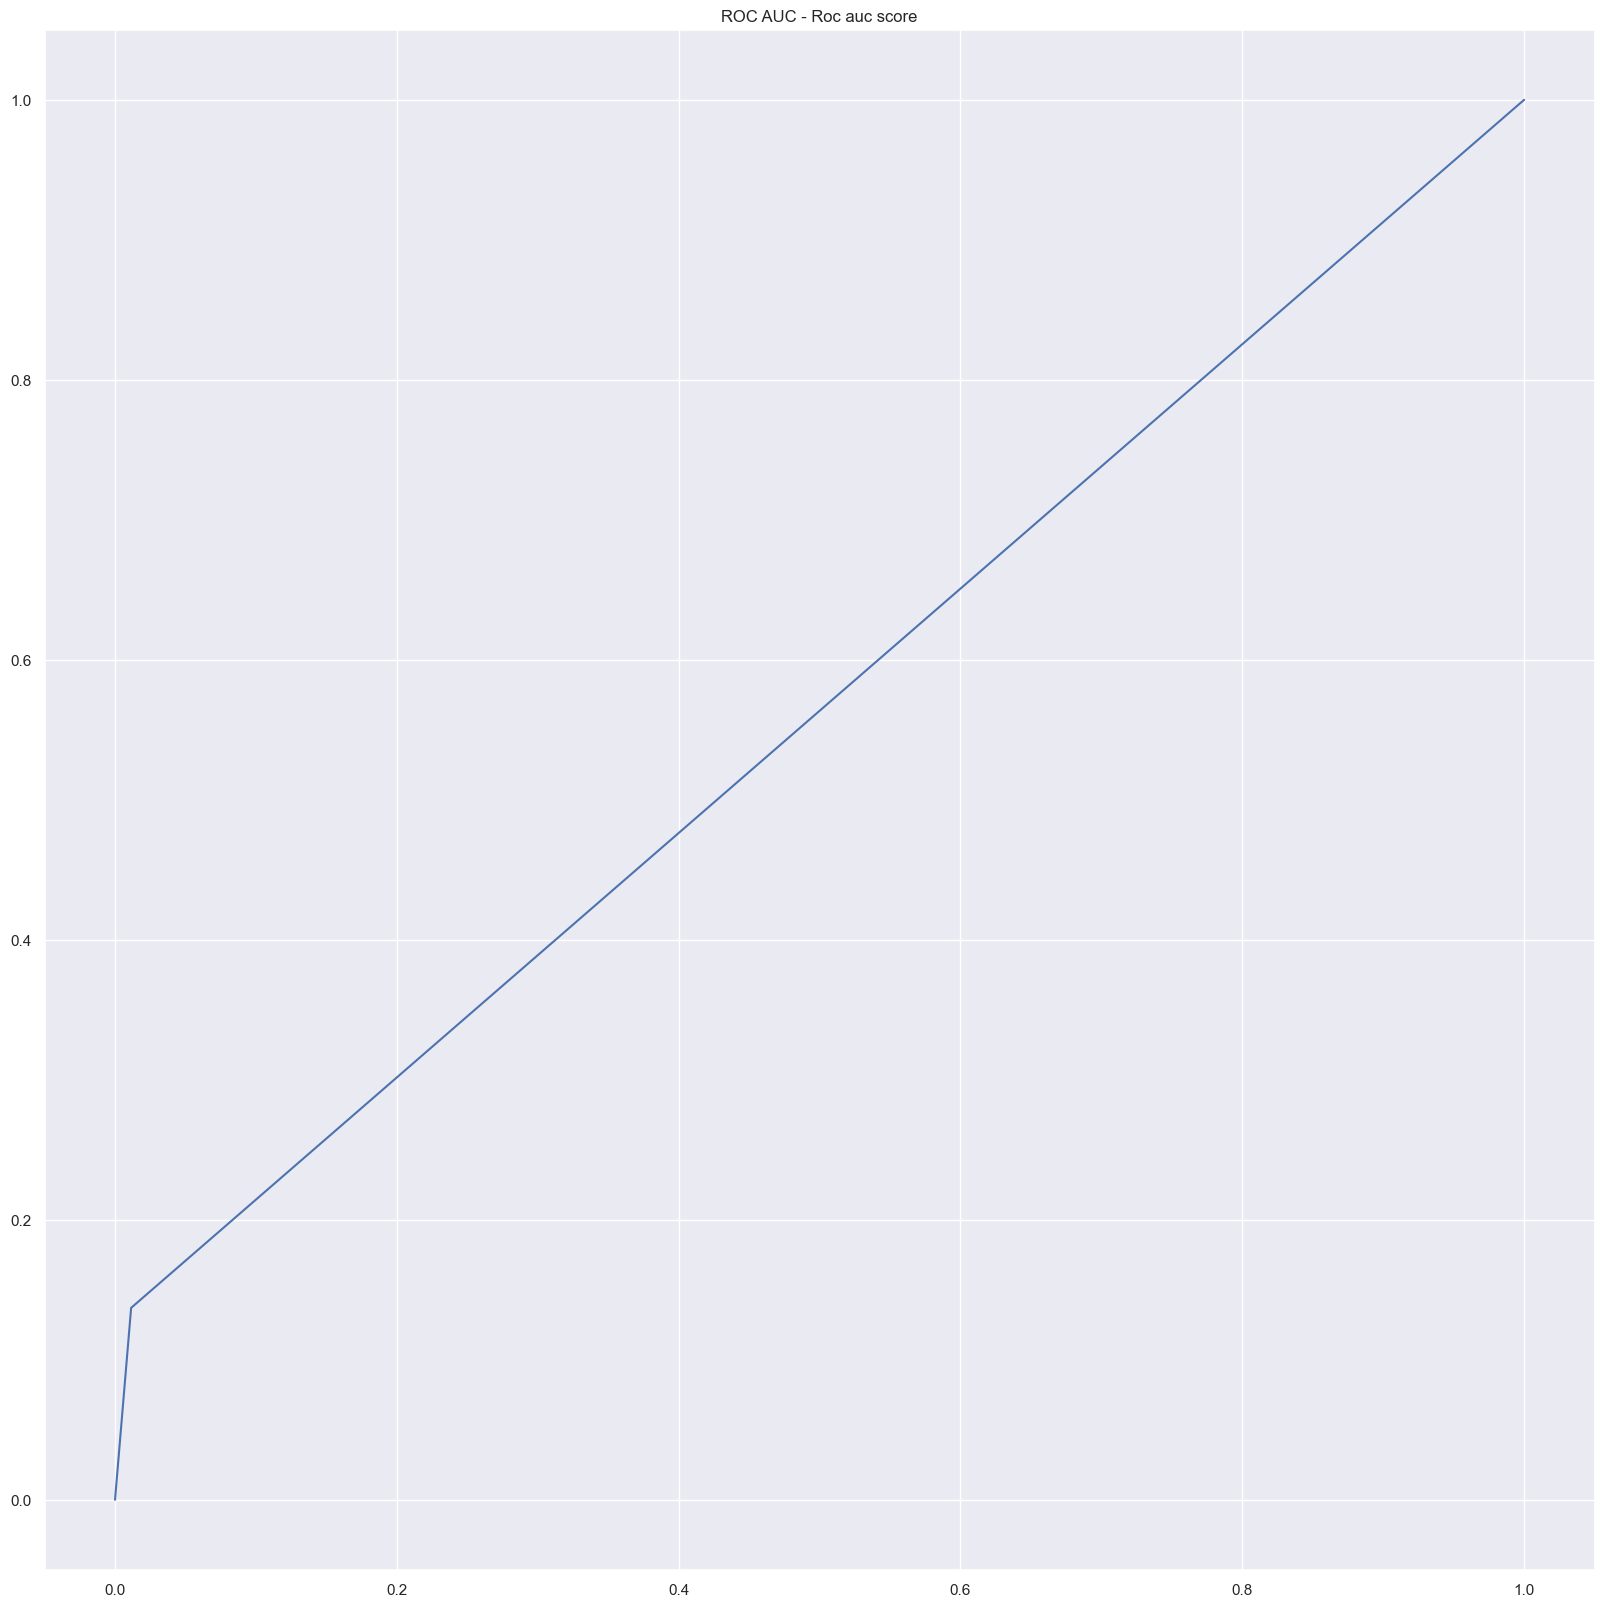

Модель - Метод опорных векторов
Accuracy - 0.8762135922330098
Precision - 0.7391304347826086
Recall - 0.27419354838709675
F1 - 0.39999999999999997
Roc auc score - 0.6285253456221198


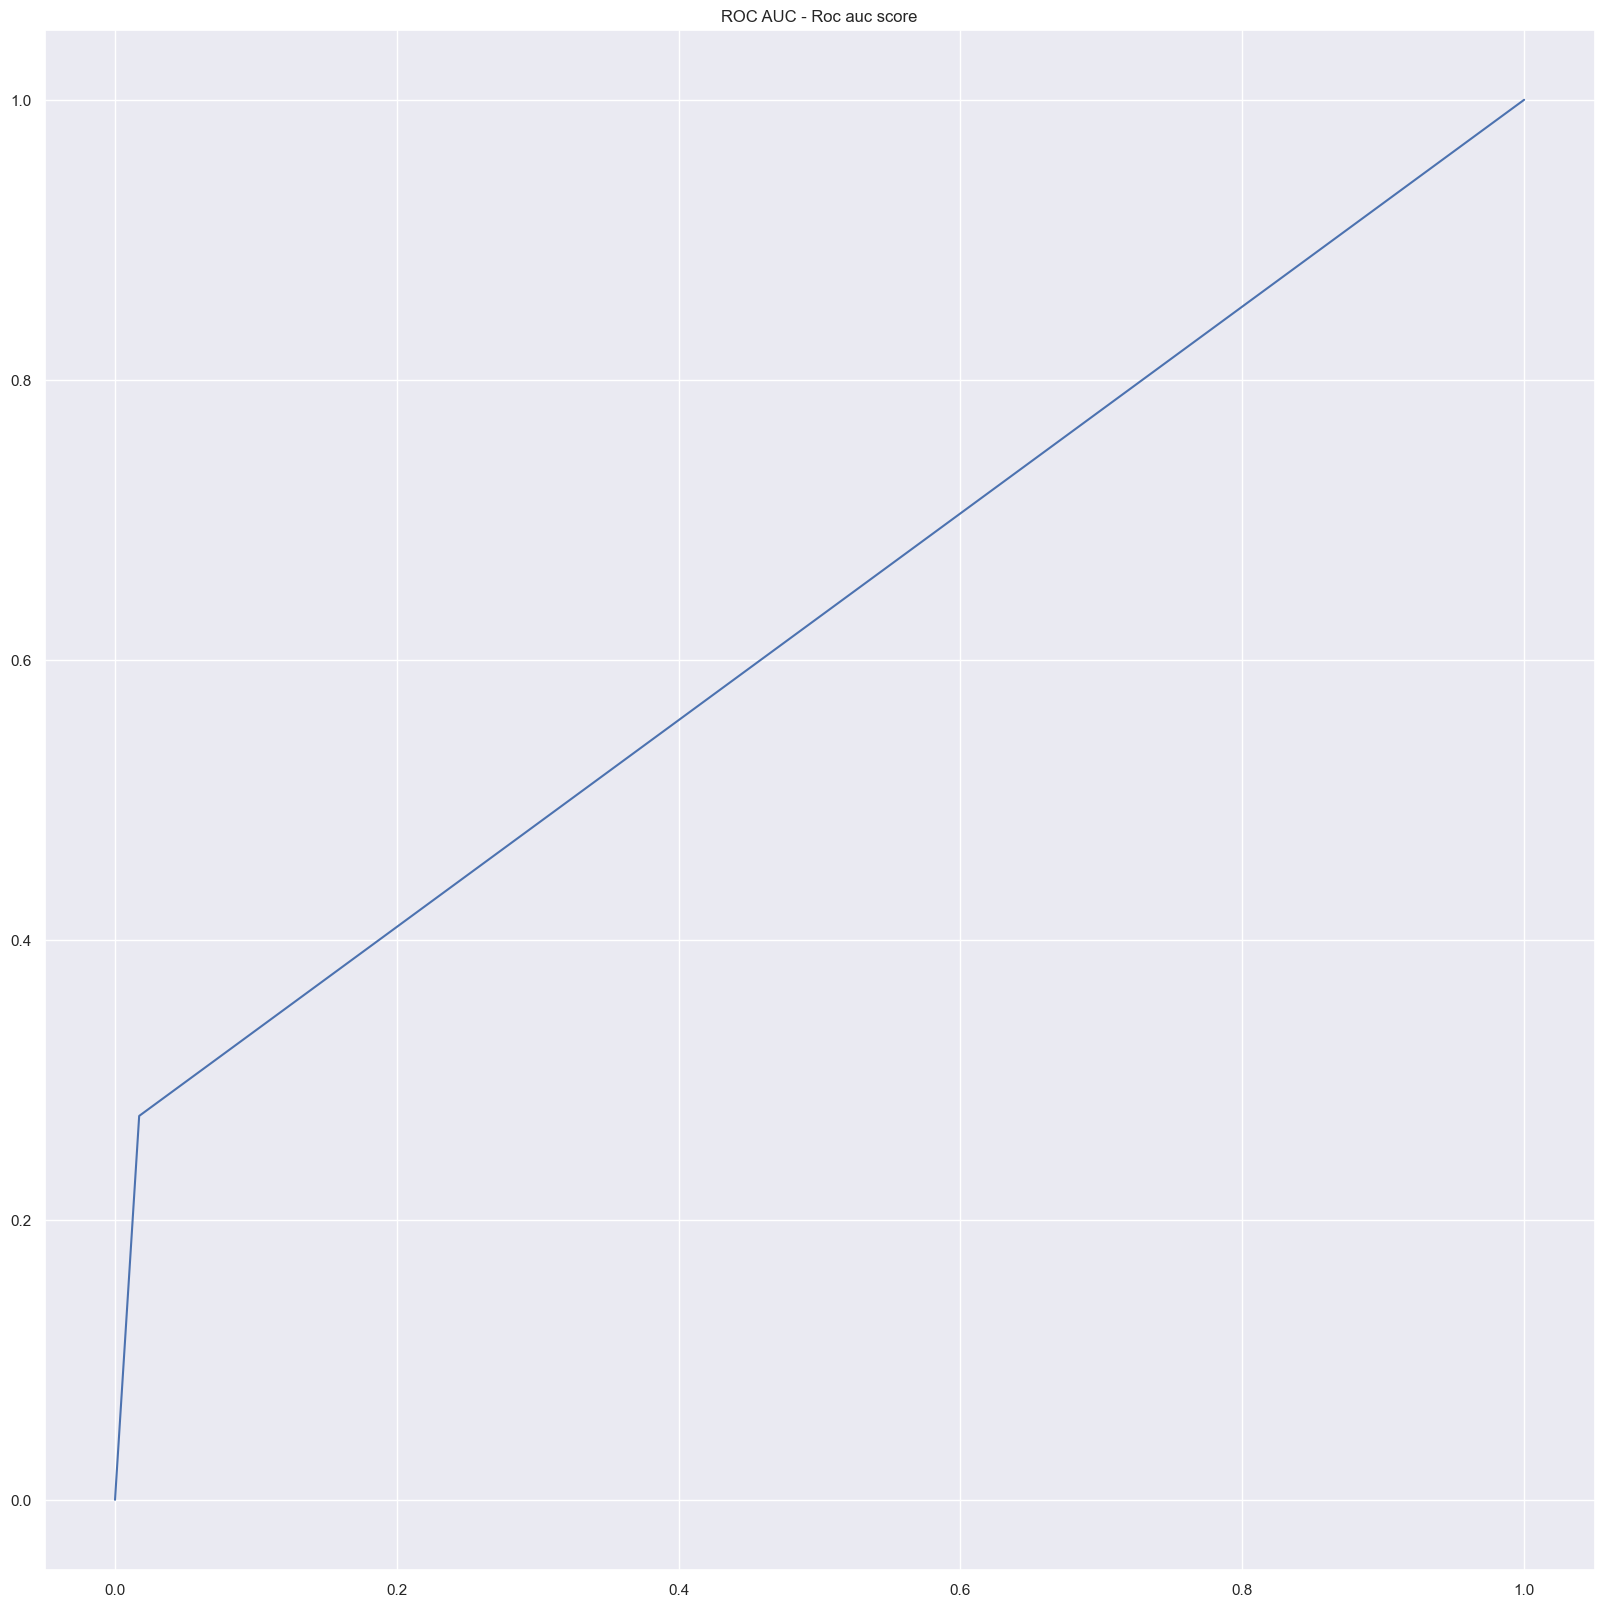

In [29]:
x_train, x_test, y_train, y_test = train_test_split(dataframe[selected_columns], dataframe[OUTPUT_COLUMN])
best_models = get_best_models(models_data, x_train, y_train)
for name, model in best_models.items():
    predicted = model.predict(x_test)
    print(f"Модель - {name}")
    metrics = get_metrics(y_test, predicted)
    methods_and_scores['Встроенные методы отбора признаков'] = metrics
    for name, value in metrics.items():
        print(f"{name} - {value}")
    create_roc_curve(y_test, predicted, name=name)

# Сэмплирование

Oversampling

In [30]:
print(dataframe[OUTPUT_COLUMN].value_counts())
x_resampled, y_resampled = SMOTE().fit_resample(dataframe.drop(columns=OUTPUT_COLUMN), dataframe[OUTPUT_COLUMN])
print(y_resampled.value_counts())


Churn
False    2826
True      469
Name: count, dtype: int64
Churn
False    2826
True     2826
Name: count, dtype: int64


Модель - К-ближайших соседей
Accuracy - 0.8853503184713376
Precision - 0.8191365227537923
Recall - 0.9901269393511989
F1 - 0.8965517241379312
Roc auc score - 0.884978242402872


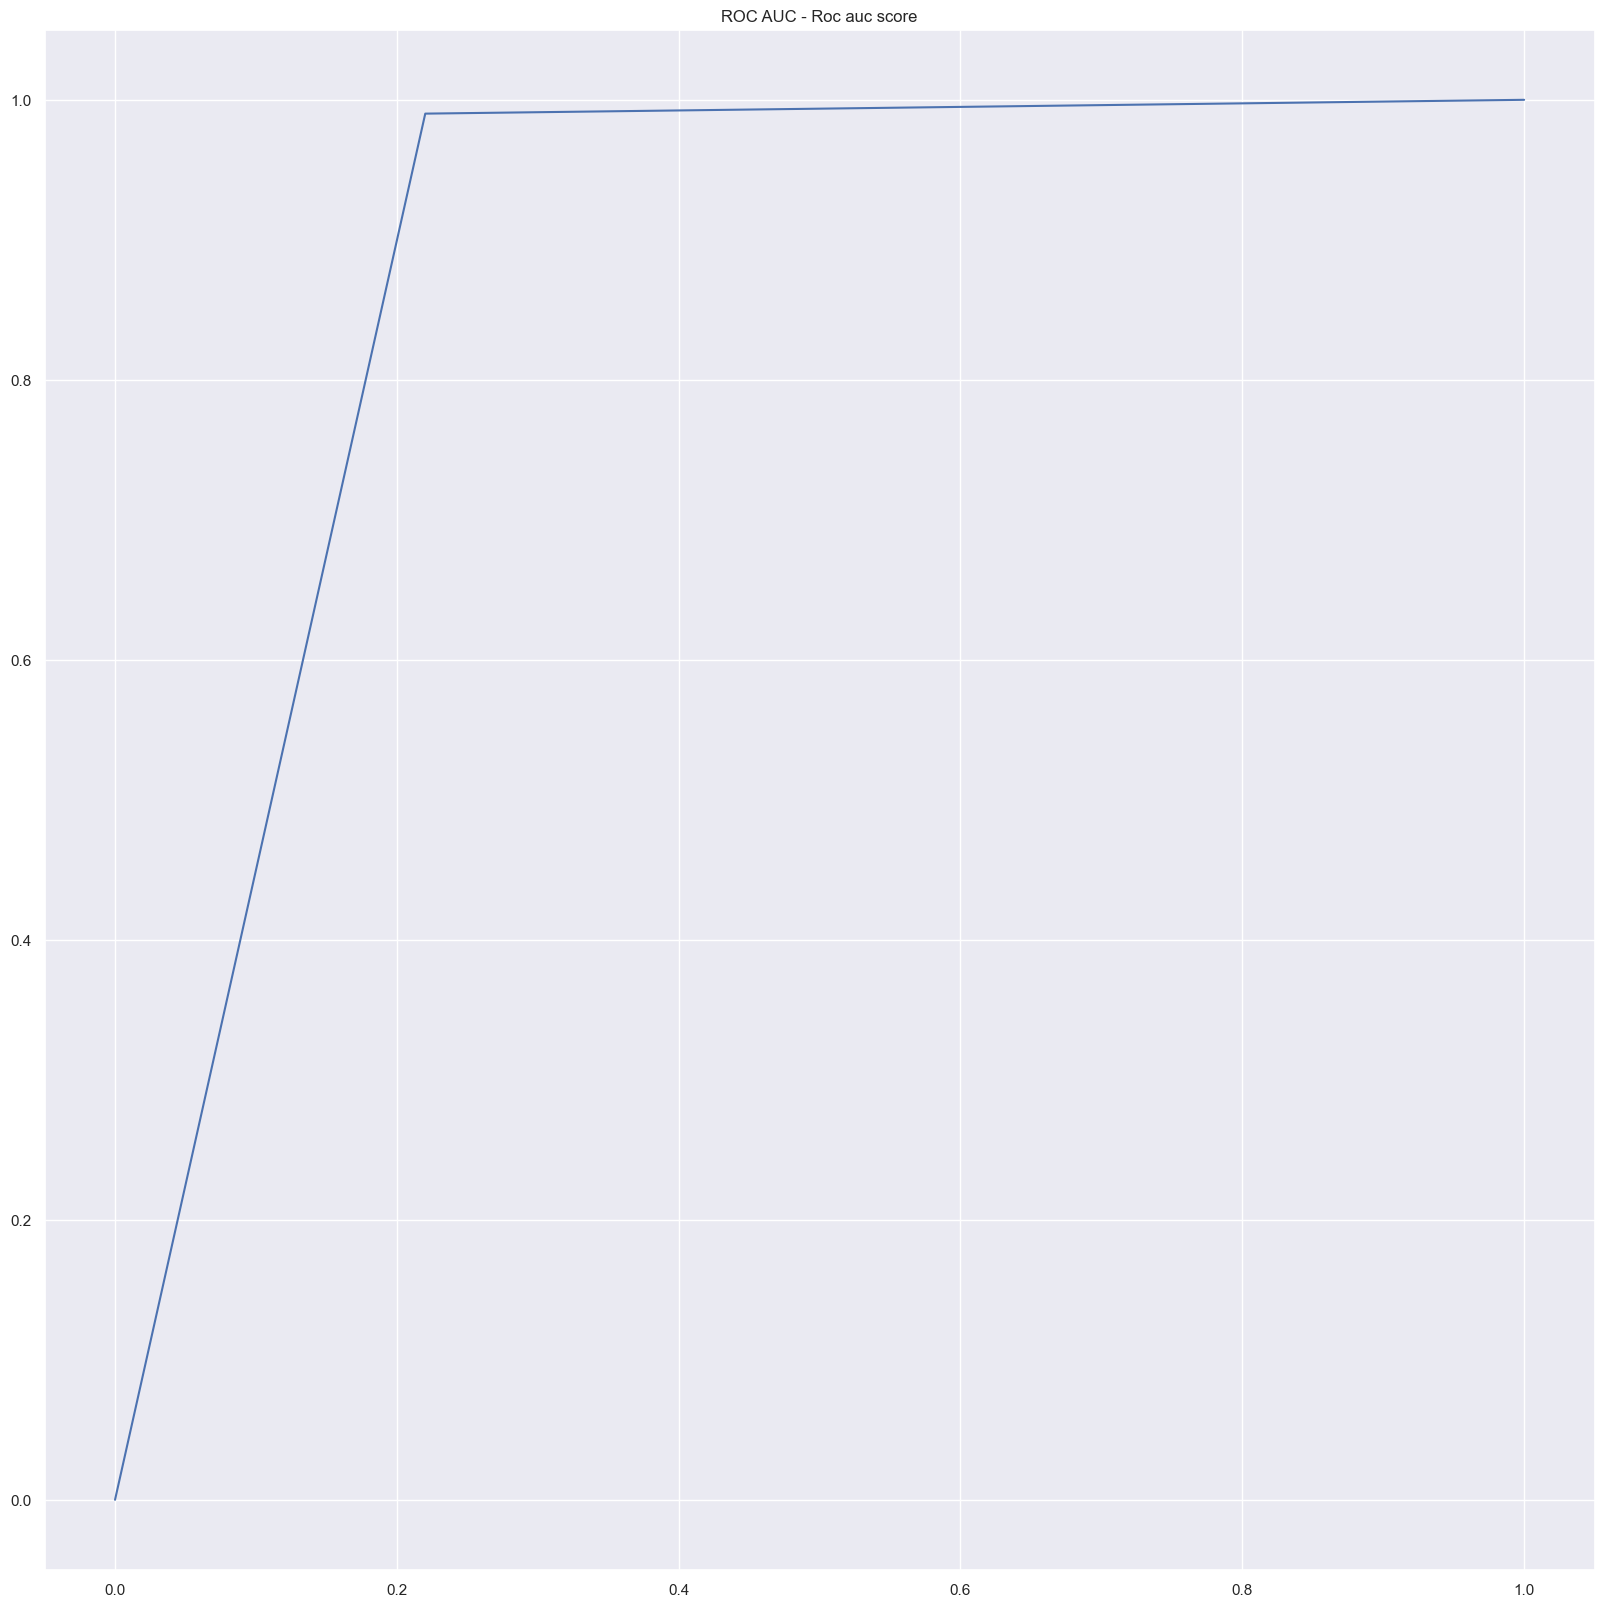

Модель - Логистическая регрессия
Accuracy - 0.7799009200283086
Precision - 0.7763888888888889
Recall - 0.7884344146685472
F1 - 0.7823652904128761
Roc auc score - 0.7798706164251826


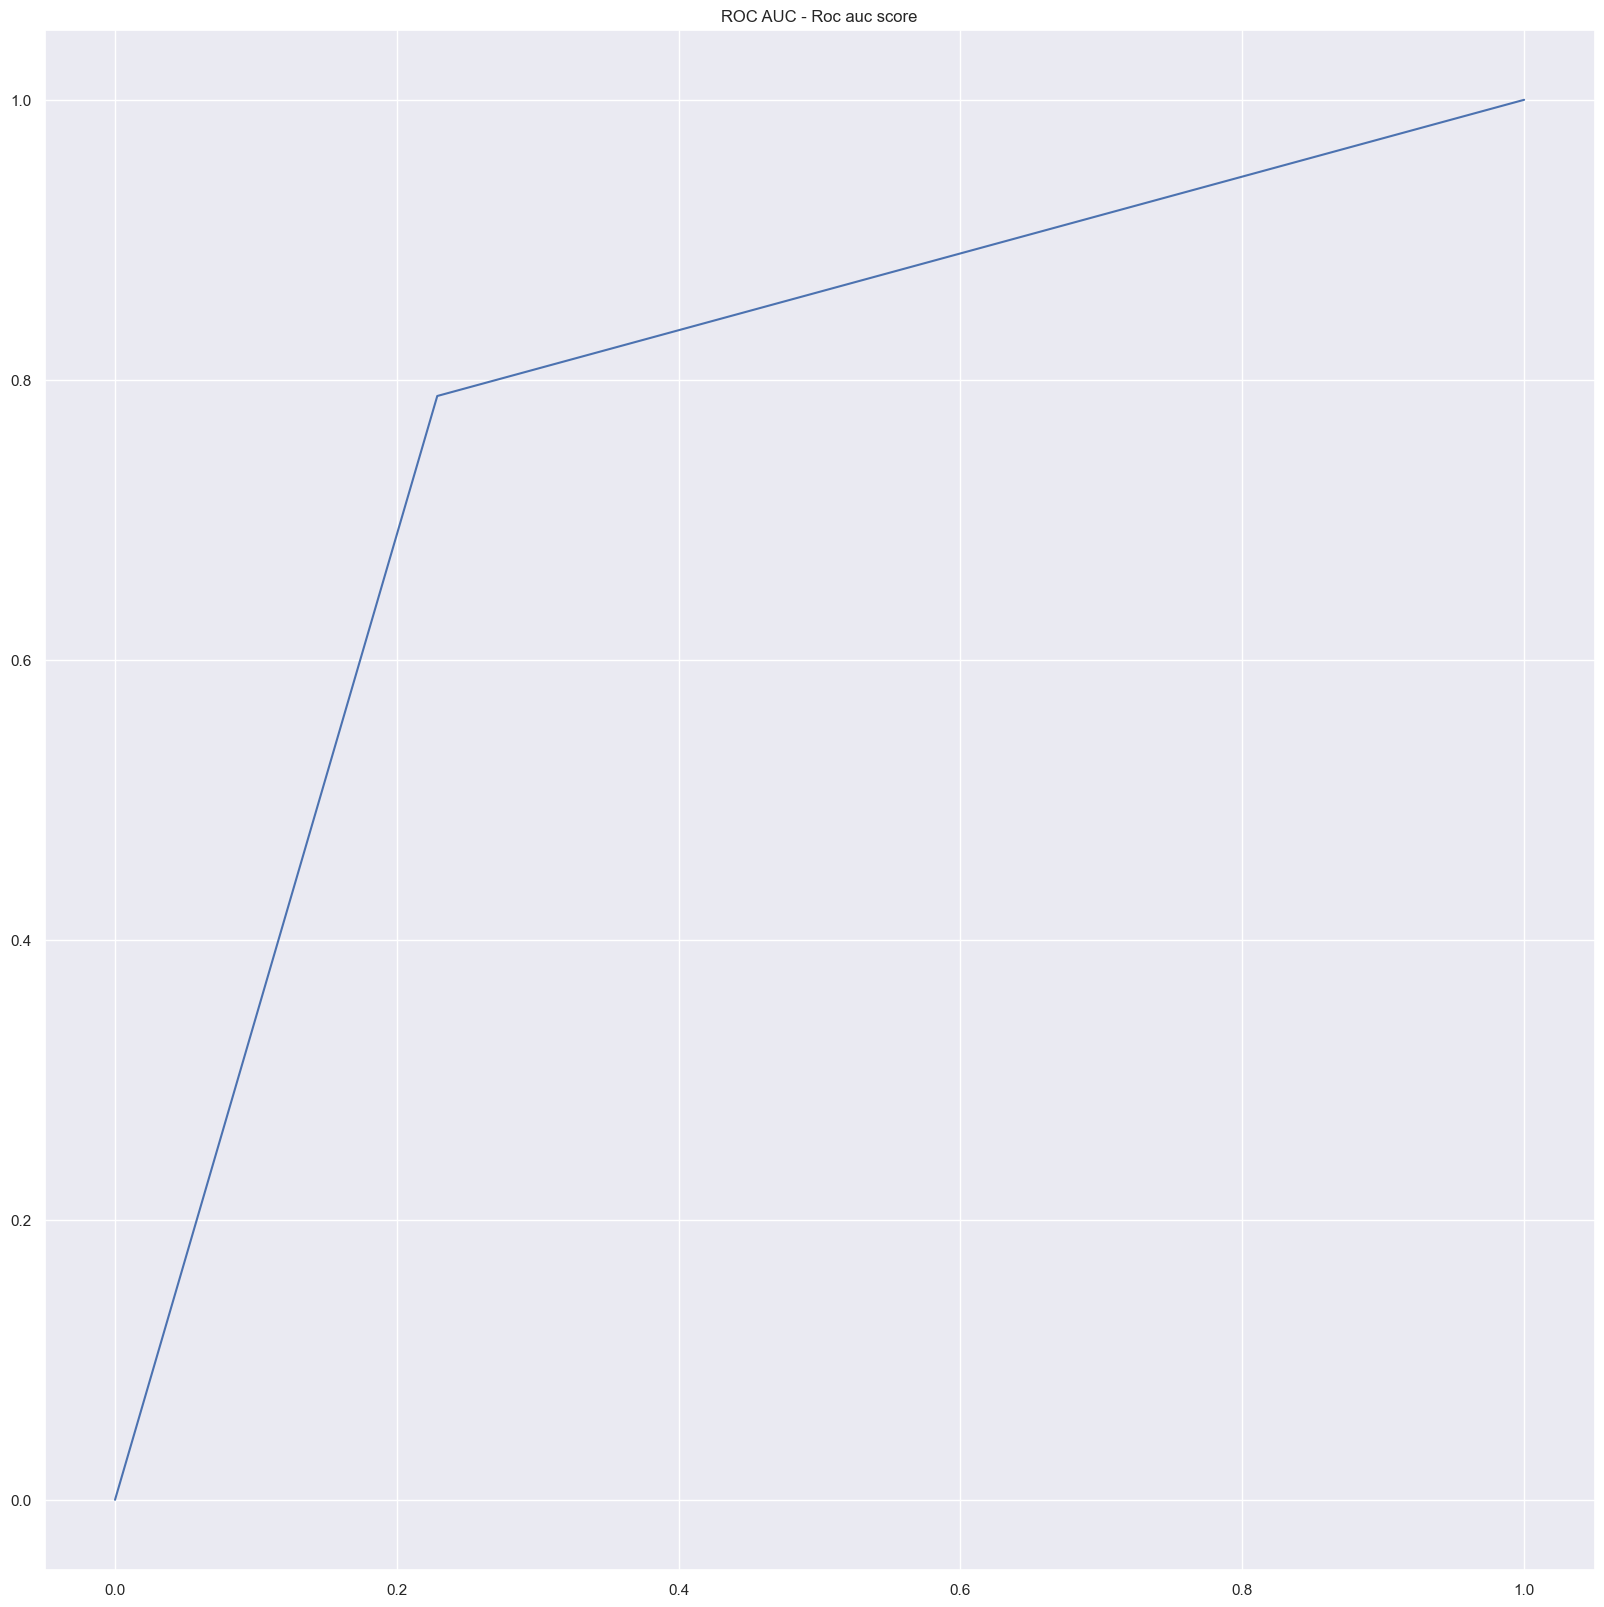

Модель - Метод опорных векторов
Accuracy - 0.9094125973106865
Precision - 0.9167862266857962
Recall - 0.9012693935119888
F1 - 0.9089615931721196
Roc auc score - 0.9094415149378126


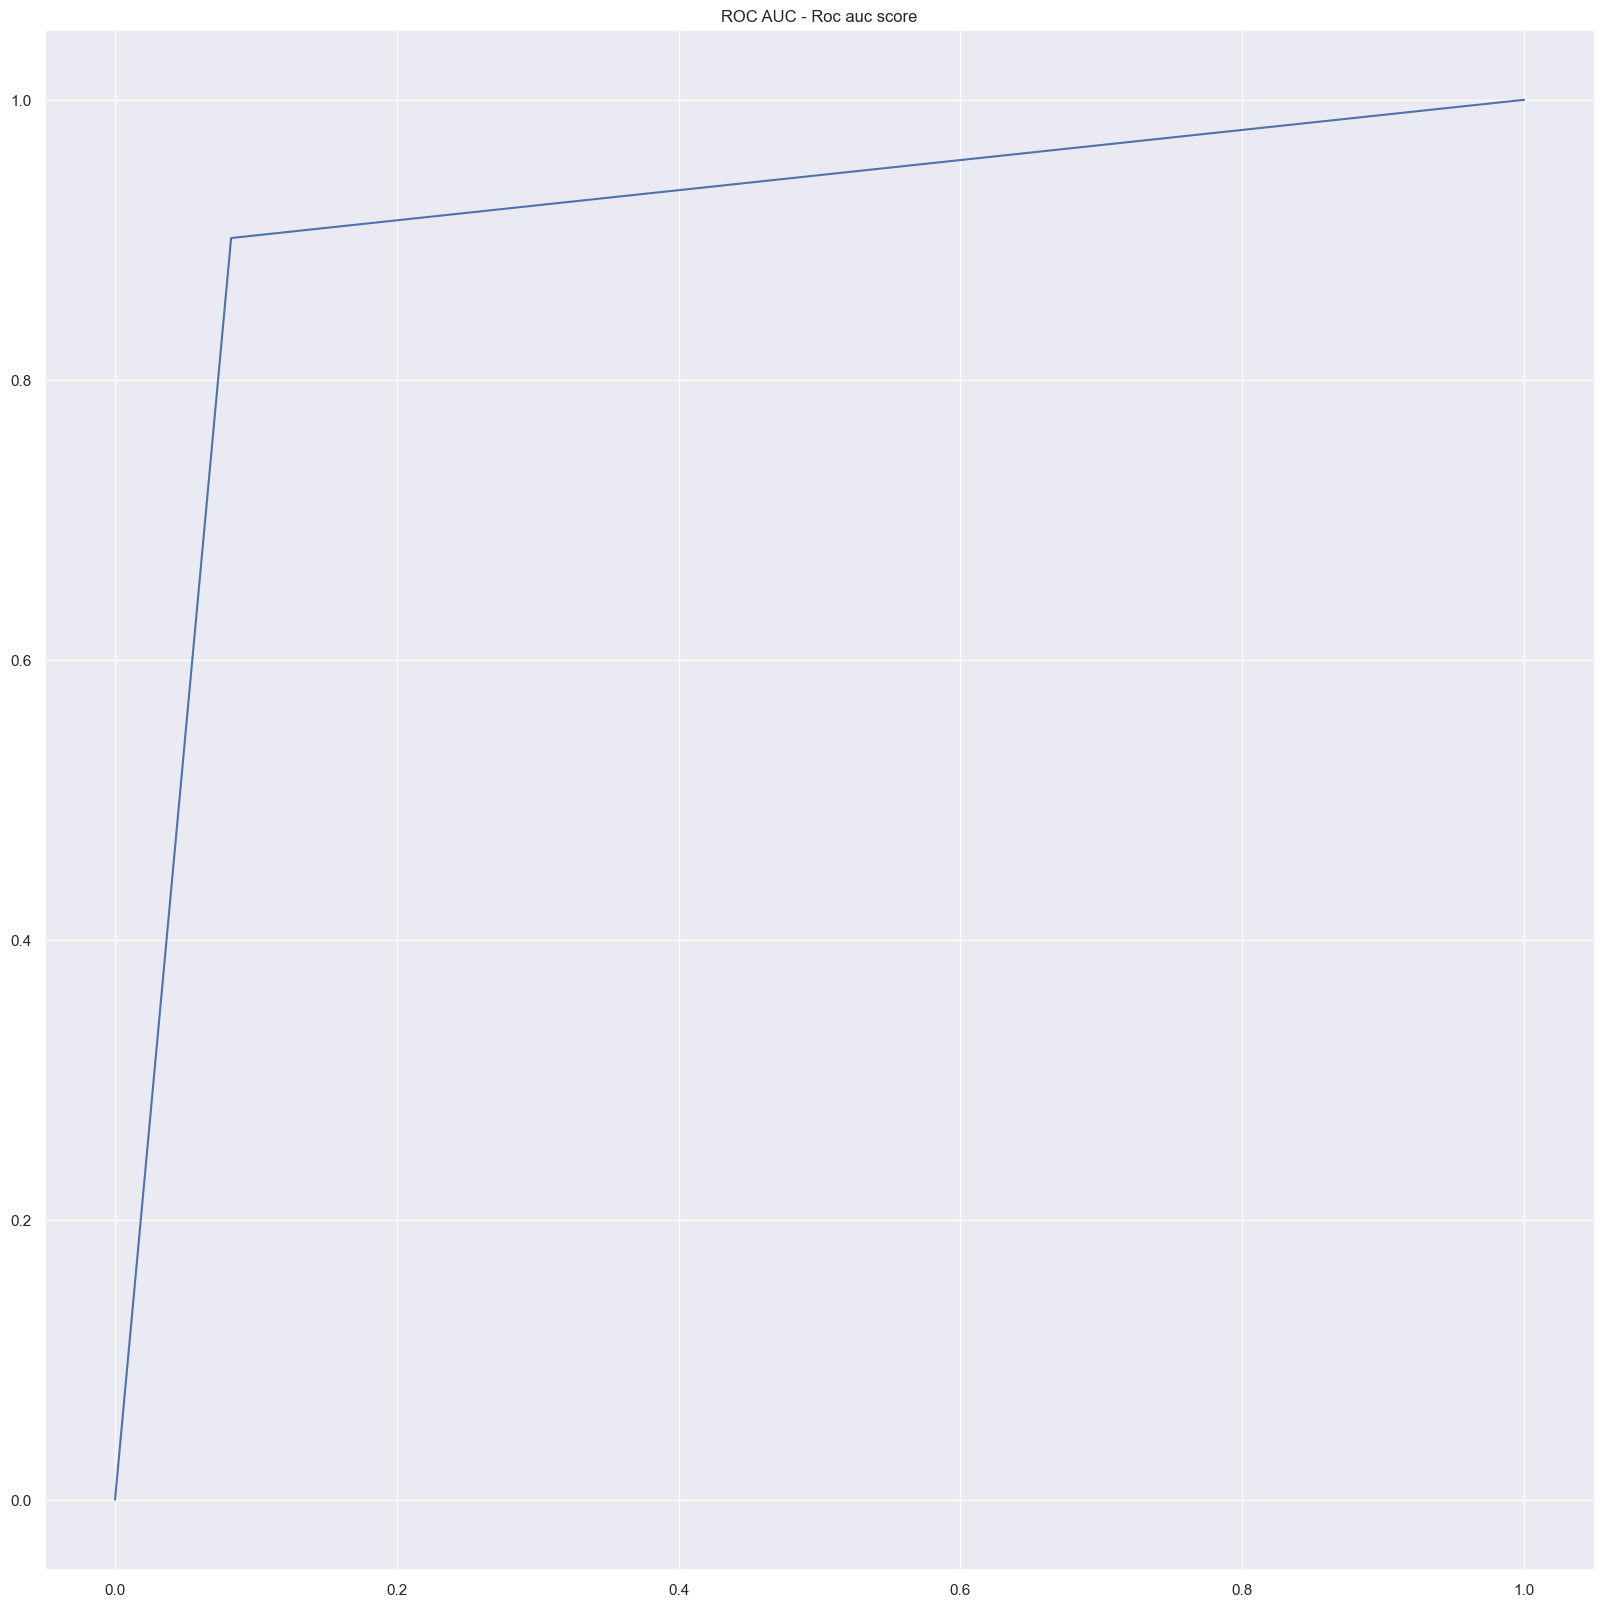

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled)
best_models = get_best_models(models_data, x_train, y_train)
for name, model in best_models.items():
    predicted = model.predict(x_test)
    print(f"Модель - {name}")
    metrics = get_metrics(y_test, predicted)
    methods_and_scores['Овэрсэмплинг'] = metrics
    for name, value in metrics.items():
        print(f"{name} - {value}")
    create_roc_curve(y_test, predicted, name=name)

Undersampling

In [32]:
print(dataframe[OUTPUT_COLUMN].value_counts())
x_resampled, y_resampled = TomekLinks().fit_resample(dataframe.drop(columns=OUTPUT_COLUMN), dataframe[OUTPUT_COLUMN])
print(y_resampled.value_counts())

Churn
False    2826
True      469
Name: count, dtype: int64
Churn
False    2731
True      469
Name: count, dtype: int64


Модель - К-ближайших соседей
Accuracy - 0.89625
Precision - 0.71875
Recall - 0.23711340206185566
F1 - 0.3565891472868217
Roc auc score - 0.6121555630508425


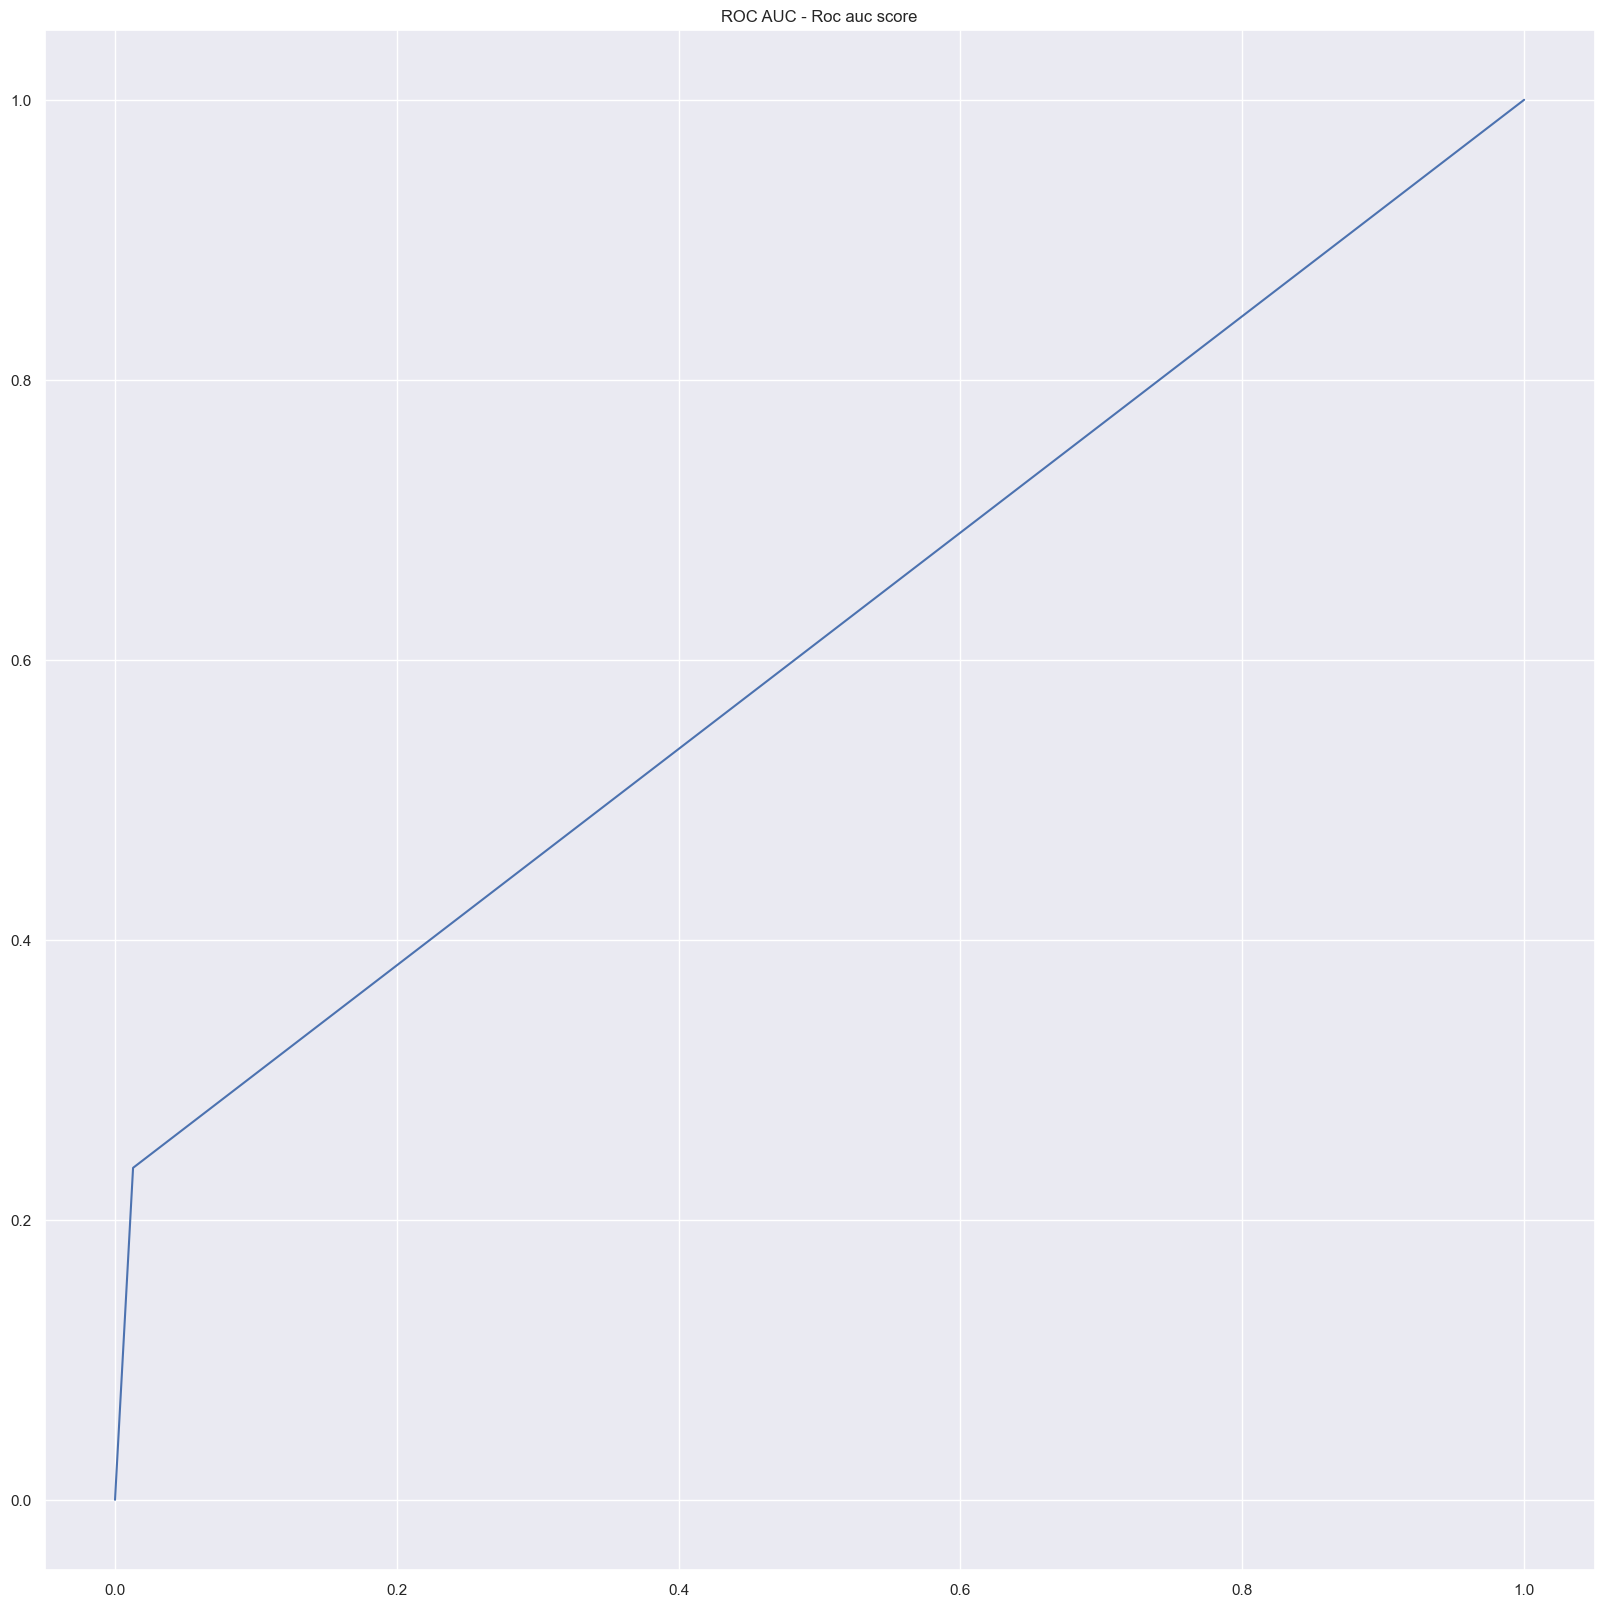

Модель - Логистическая регрессия
Accuracy - 0.8775
Precision - 0.4909090909090909
Recall - 0.27835051546391754
F1 - 0.35526315789473684
Roc auc score - 0.6192606062383599


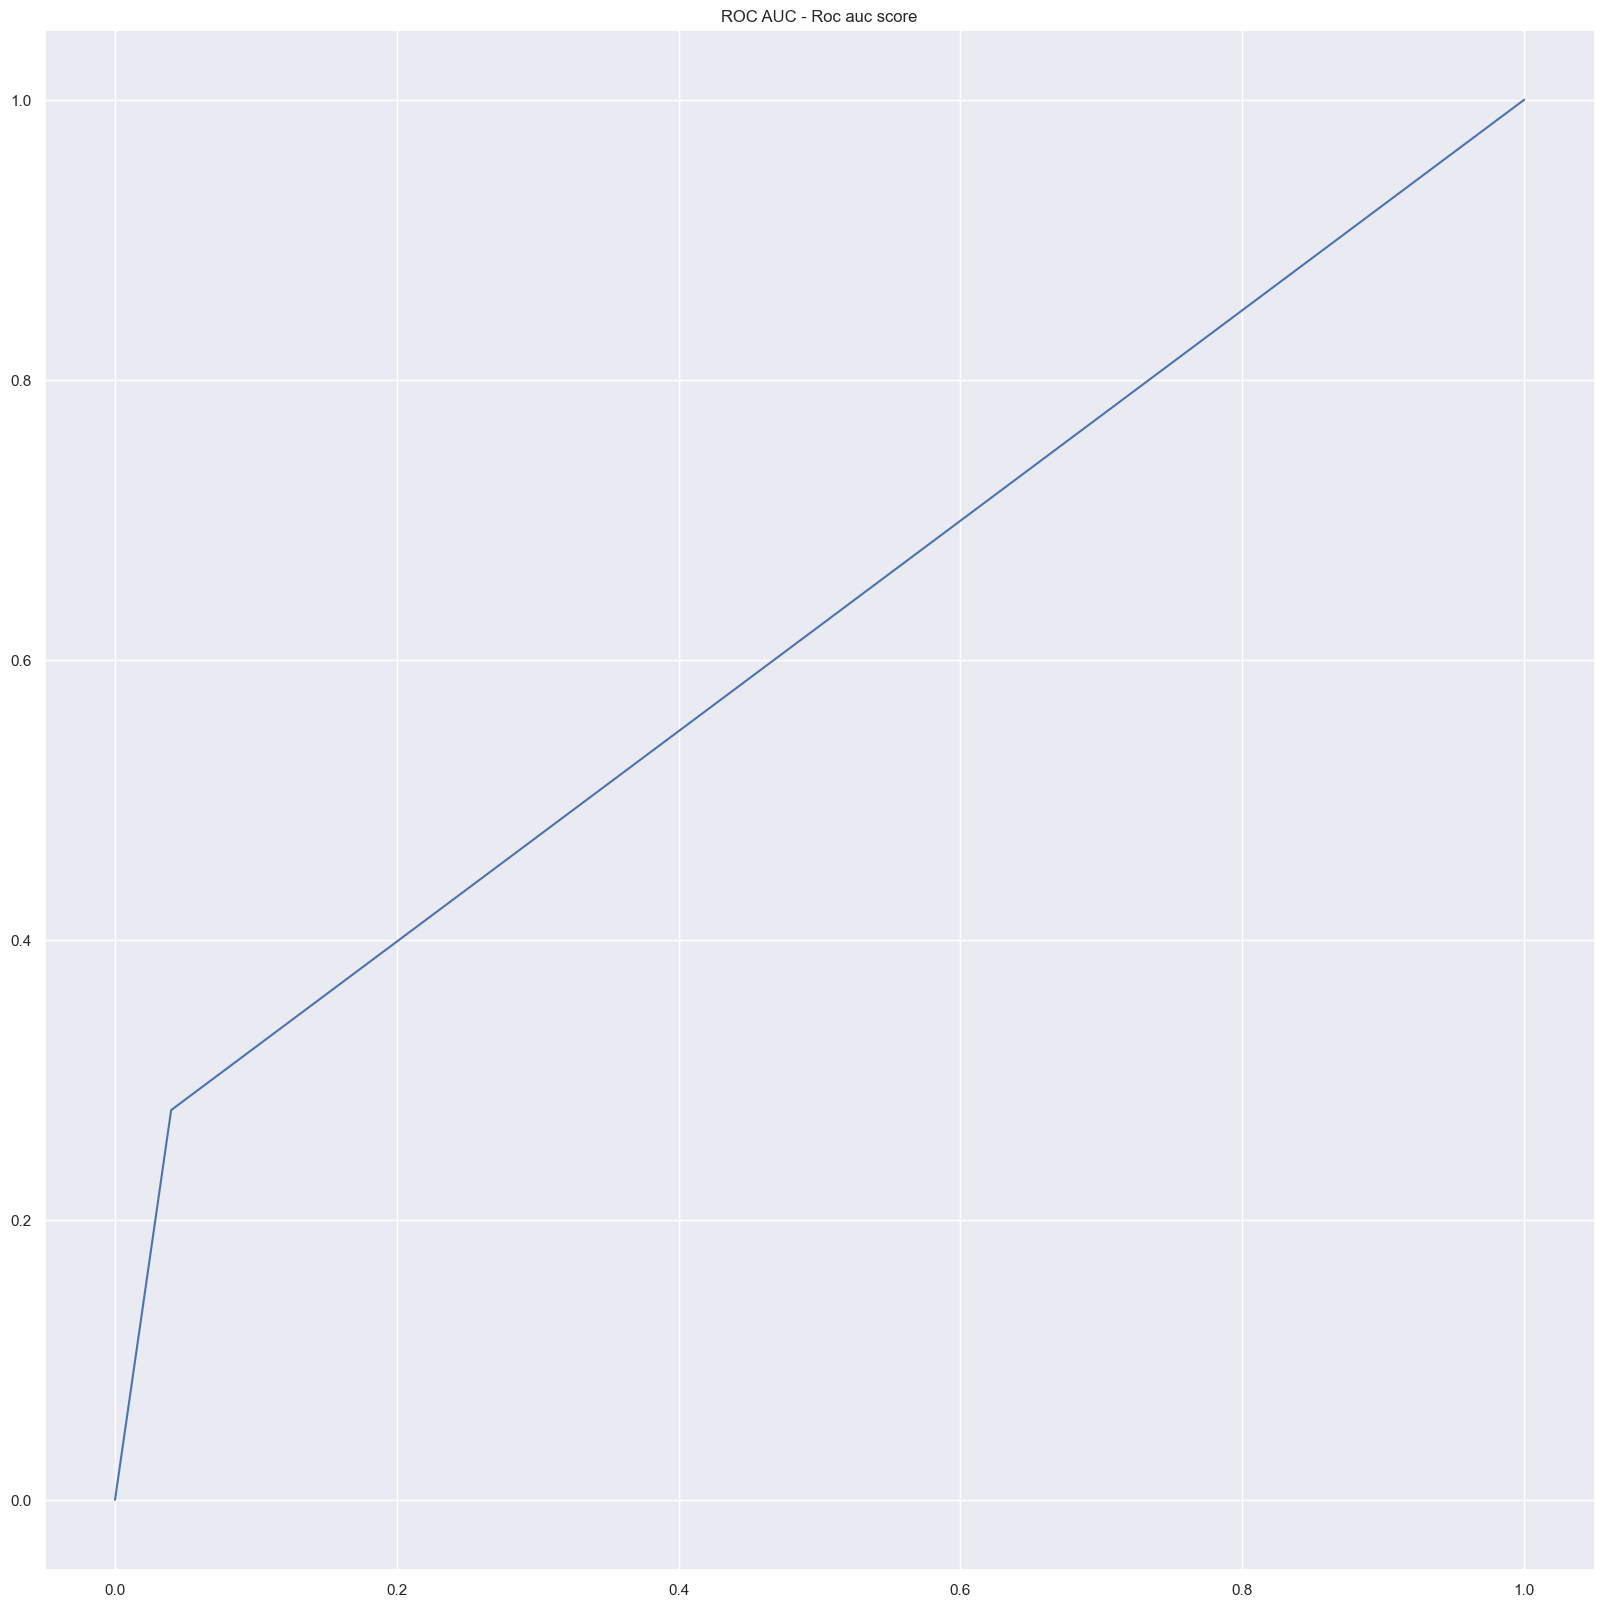

Модель - Метод опорных векторов
Accuracy - 0.92875
Precision - 0.8225806451612904
Recall - 0.5257731958762887
F1 - 0.6415094339622642
Roc auc score - 0.7550629848513732


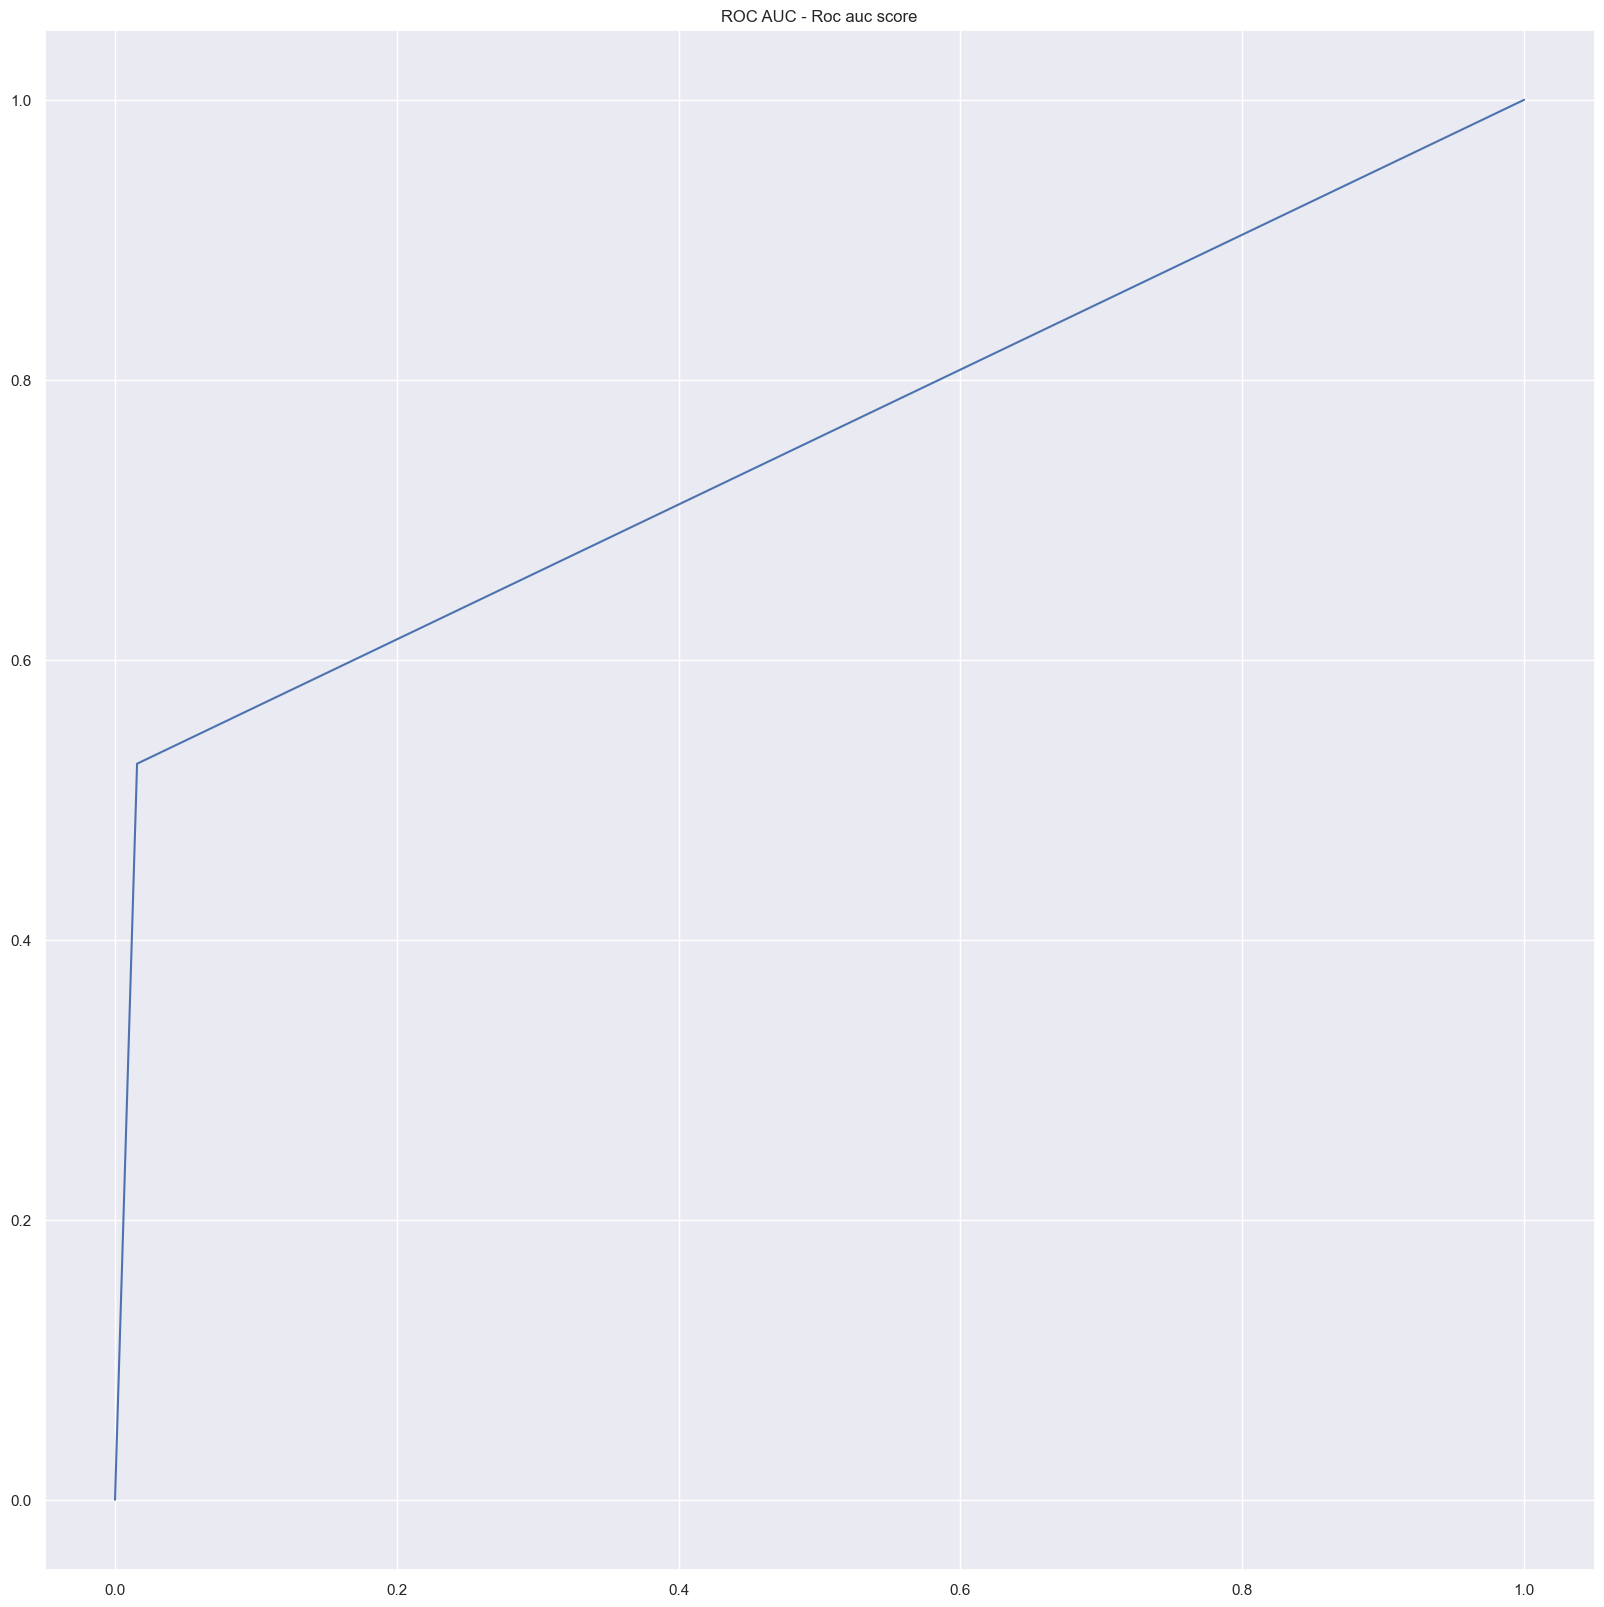

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled)
best_models = get_best_models(models_data, x_train, y_train)
for name, model in best_models.items():
    predicted = model.predict(x_test)
    print(f"Модель - {name}")
    metrics = get_metrics(y_test, predicted)
    methods_and_scores['Андэрсэмплинг'] = metrics
    for name, value in metrics.items():
        print(f"{name} - {value}")
    create_roc_curve(y_test, predicted, name=name)

# Сравнение метрик качества моделей для разных методов обработки

In [34]:
methods_and_scores['Овэрсэмплинг']["Recall"]

0.9012693935119888

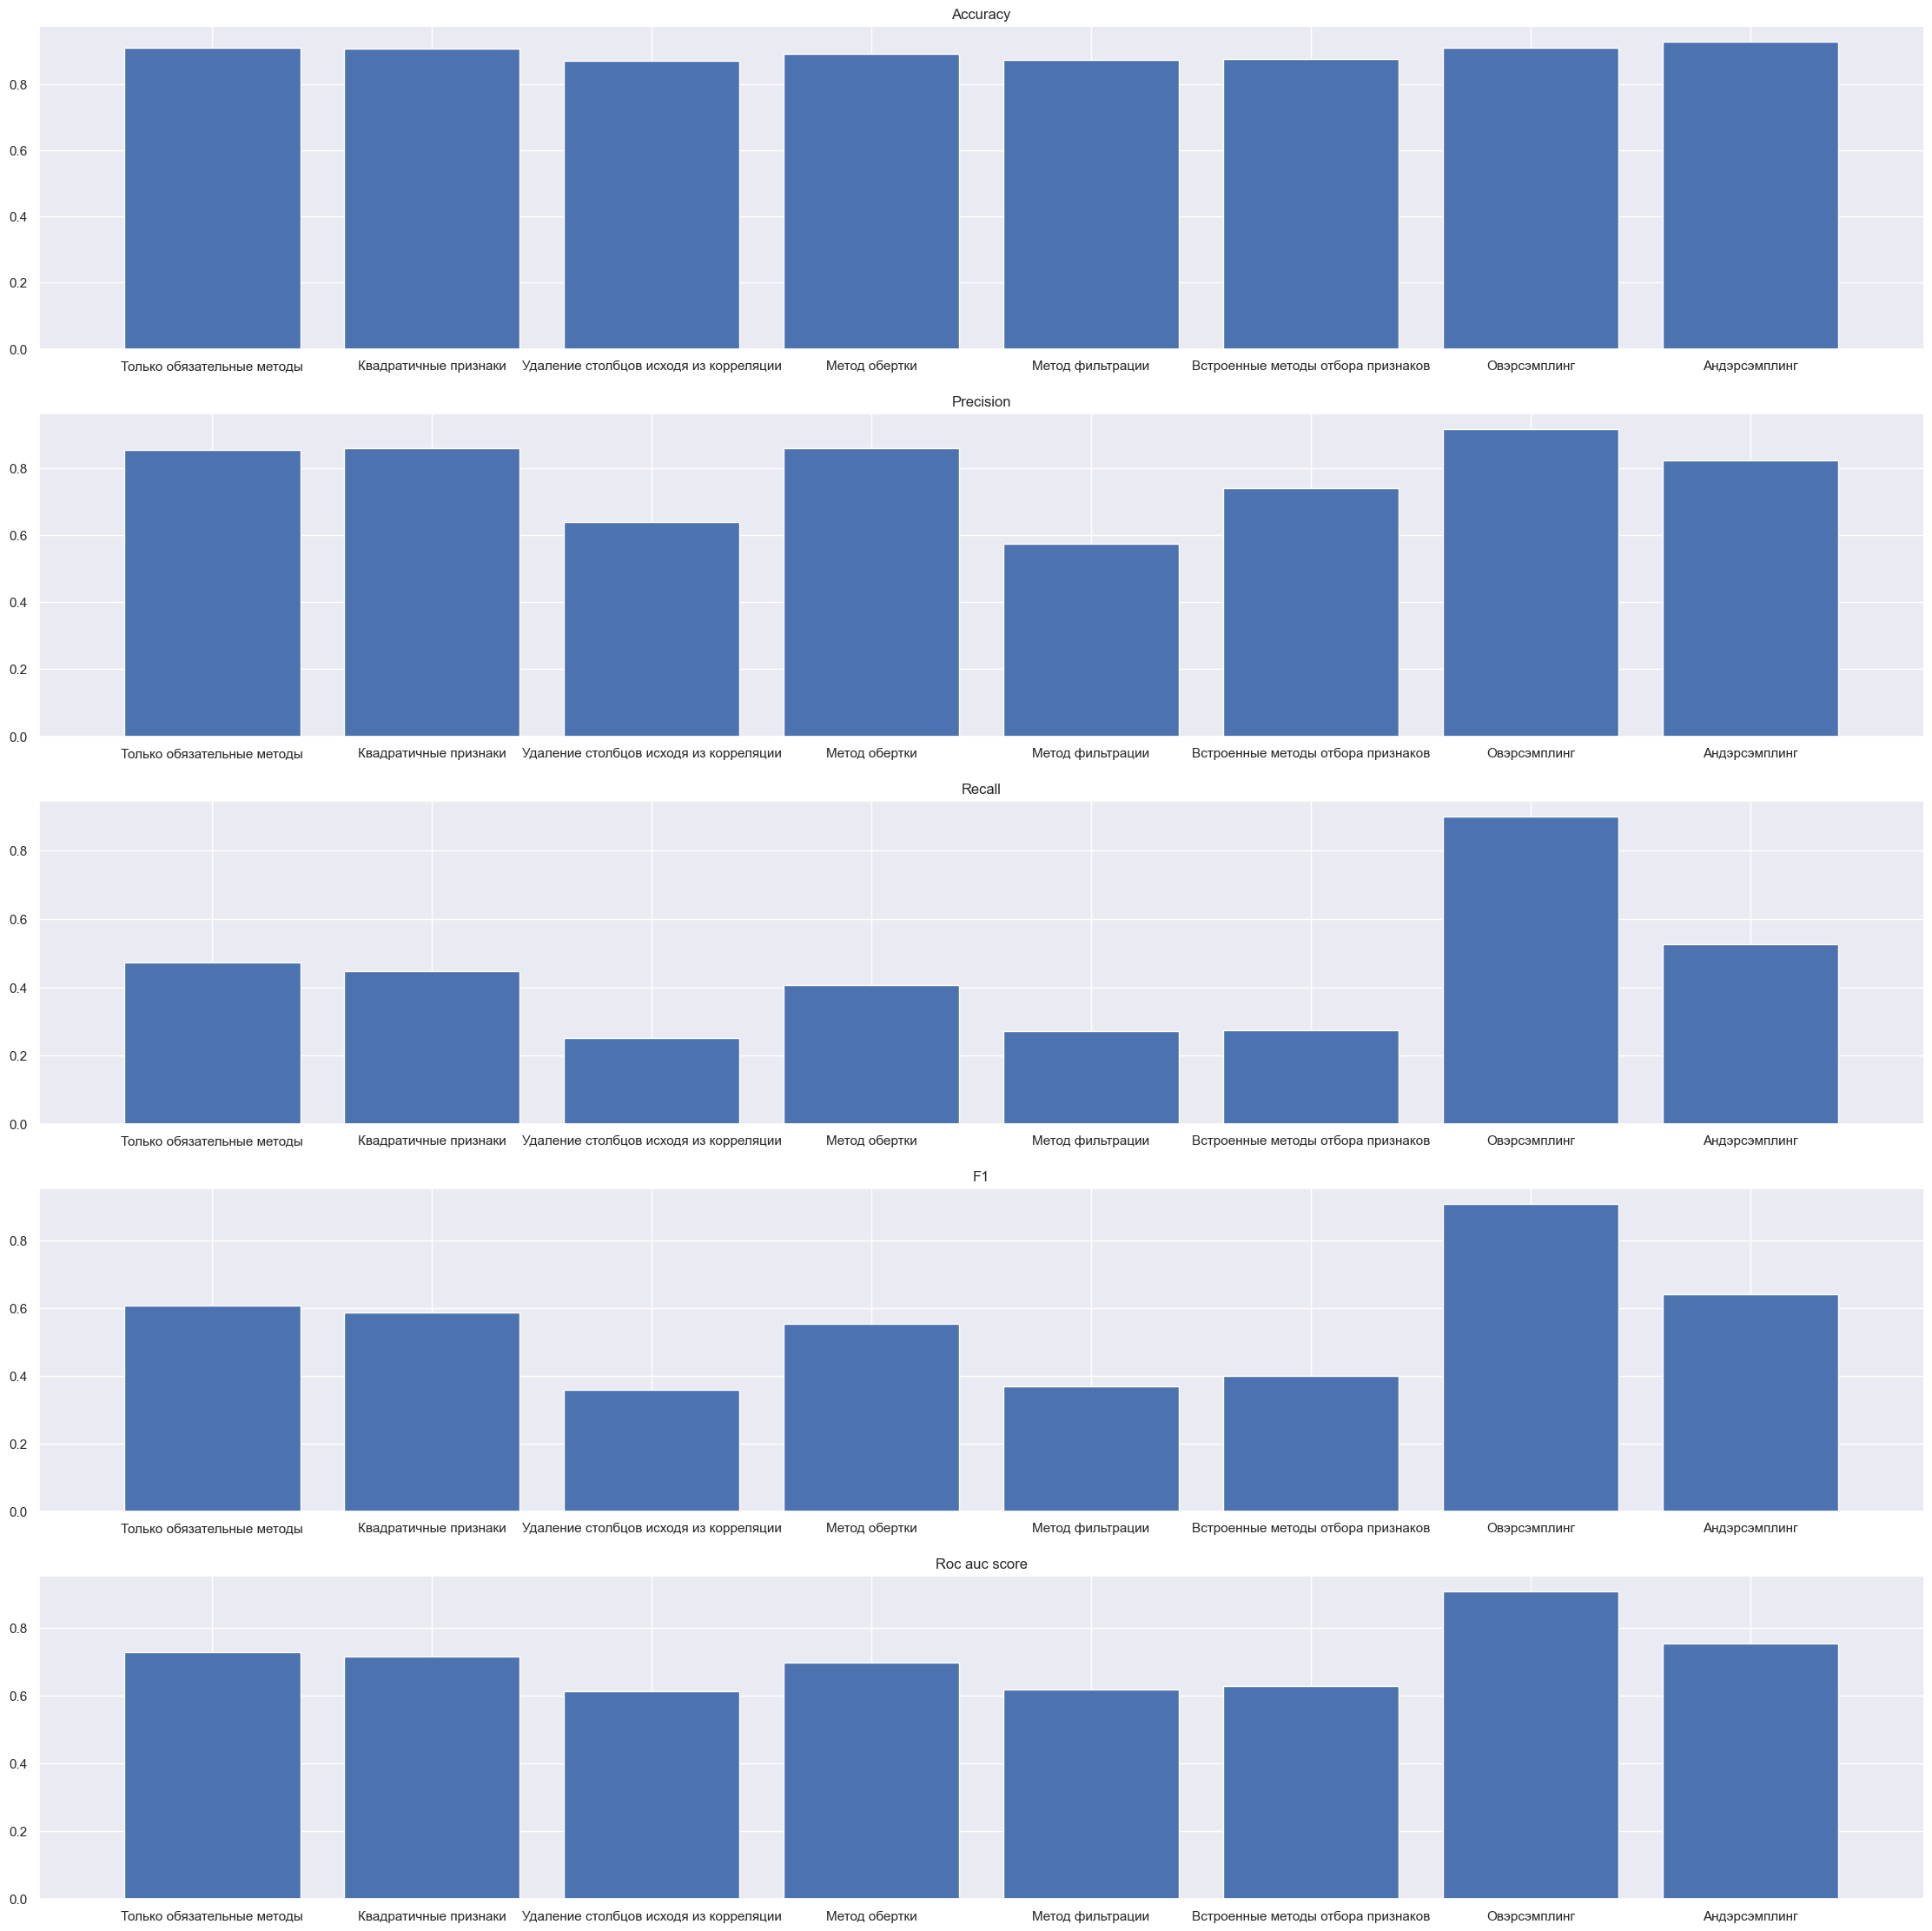

In [35]:
"""fig, ax = plt.subplots(nrows=5, ncols=len(methods_and_scores))
for method_idx, key in enumerate(methods_and_scores.keys()):
    for score_idx, score in enumerate(methods_and_scores[key].keys()):
        ax[score_idx, method_idx] = plt.bar(methods_and_scores[key].keys(), methods_and_scores[key].values)
        ax[score_idx, method_idx].set_title(key)
plt.show()"""

scoring_methods = list(methods_and_scores.values())[0]
fig, ax = plt.subplots(nrows=len(scoring_methods), figsize=(28, 28))

for scoring_idx, scoring in enumerate(scoring_methods):
    scores = list(map(lambda x: x[scoring], methods_and_scores.values()))
    ax[scoring_idx].set_title(scoring)
    ax[scoring_idx].bar(methods_and_scores.keys(), scores)
